# Software Cost Estimation

SELM-SCE 1: implementing without K-Means

SELM-SCE 2: implementing with K-Means

SELM-SCE 3: implementing without K-Means (SMOTE)

SELM-SCE 4: implementing with K-Means (SMOTE)

In [74]:
# !pip install scikit-learn==0.23.2
# !pip install numpy==1.19
# !pip install pandas

# use python3.8
# https://stackoverflow.com/questions/67874416/unable-to-install-sklearn-0-23-2-with-pip-20-2-4-and-python-3-9
# https://stackoverflow.com/questions/67286728/installing-a-ipykernel-and-running-jupyter-notebook-inside-a-virtual-env-not-u
# https://stackoverflow.com/questions/63168301/how-to-change-the-python-version-from-default-3-5-to-3-8-of-google-colab



# Import Libraries 

In [75]:
import time
import math
import argparse
import pickle
import smogn
import numpy as np
import pandas as pd
# 
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, auc, balanced_accuracy_score, roc_auc_score, roc_curve
from sklearn.svm import SVR, SVC, LinearSVC 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, Perceptron, BayesianRidge, LogisticRegression, LassoCV, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import StackingRegressor, StackingClassifier, RandomForestClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
# 
from joblib import dump, load
import dataclasses
from dataclasses import dataclass
from typing import List, Dict, Tuple, Any, Optional

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [76]:
np.random.seed(10)


# Process Data

## Encode Feature Labels

In [77]:
class EncodeFeatureLabelValues(BaseEstimator, TransformerMixin):
    """
        This is a Class Used to Preprocess the data, By
        encoding N features and filling missing values
        too
    """
    
    def __init__(self, all_features=['size_D', 'duration_D', 'app', 'har', 
                                    'dba', 'ifc', 'source', 'nlan',
                                    'telonuse', 't01', 't02', 't03', 
                                    't04', 't05', 't06', 't07', 't08',
                                    't09', 't10', 't11', 't12', 't13', 
                                    't14', 't15'],  
                        
                        to_encode=['app','har', 'dba', 'ifc', 'source', 
                                    'nlan','telonuse']):
    
        #Read in data
        self.features = all_features
        self.to_encode = to_encode

    def fit(self,X):
        #check if features are present
        try:
            X = X[self.features]
        except Exception as exp:
            raise exp

        self.all_encode = {each_feature : LabelEncoder().fit(X[each_feature]) for each_feature in self.to_encode}
        return self #do nothing

    def transform(self,X):
        """
            Work on the dataset
        """
        #check if features are present
        try:
            X = X[self.features]
        except Exception as exp:
            raise exp
            
        #Replace Labels with numerical values
        for each_feature in self.to_encode:
            X[each_feature] = self.all_encode[each_feature].transform(X[each_feature])
            classes_ = self.all_encode[each_feature].classes_
            none_index = np.where(classes_ == 'NaN')[0]
            if none_index.shape[0] >= 1:
                none_index = int(none_index)
                X[each_feature].replace(none_index,np.nan,inplace=True)
        return X



## Fill Empty Spaces

In [78]:
class FillEmptySpacesValues(BaseEstimator, TransformerMixin):
    """
        This is a Class Used to Preprocess the data, By
        Filling Missing Values with Standard Values That
        Represents Missing Values, e.g numpy.nan.
    """
    
    def __init__(self, all_features=[   'TeamExp', 'ManagerExp', 'YearEnd','Length', 
                                        'Transactions','Entities','PointsAdjust', 
                                        'Envergure','PointsNonAjust', 'Langage','Effort'],

                        find_in=[   'TeamExp', 'ManagerExp', 'YearEnd','Length', 
                                    'Transactions','Entities','PointsAdjust', 
                                    'Envergure','PointsNonAjust', 'Langage','Effort'],
                                        
                        find=None,
                        with_=None
                        ):
    
        #Read in data
        self.features = all_features
        self.find_in = find_in
        self.find = ['?','? ',' ?',' ? ','',' ','-',None,'None','none','Null','null',np.nan] if not find else find
        self.with_ = np.nan if not with_ else with_

    def fit(self,X):
        return self #do nothing
    def transform(self,X):
        """
            Work on the dataset
        """
        
        try:
            X = X[self.features]
        except Exception as exp:
            raise exp
            
        #Replace Missing Value With Recognized Missing Value
        X[self.find_in] = X[self.find_in].replace(self.find,self.with_)
        return X
    
    

## Round Values 

In [79]:
class RoundValues(BaseEstimator, TransformerMixin):
    """
        This is a Class Used to Preprocess the data 
        by rounding off value to nearest integer.
    """
    
    def __init__(self, all_feat=['TeamExp', 'ManagerExp', 'YearEnd','Length', 
                                'Transactions','Entities','PointsAdjust', 
                                'Envergure','PointsNonAjust', 'Langage','Effort'],
                                
                        feat_to_round=['TeamExp', 'ManagerExp','YearEnd','Length',
                                'Langage']):
    
        #Read in data
        self.feat_to_round = feat_to_round
        self.all_feat = all_feat

    def fit(self,X):
        return self #do nothing
    
    def transform(self,X):
        """
            Round Of Values In Features
        """
        
        try:
            X = pd.DataFrame(X,columns=self.all_feat)
        except Exception as exp:
            raise exp
            
        X[self.feat_to_round] = X[self.feat_to_round].apply(lambda x: round(x)).astype('int')
        
        return X
    

## OneHotEncode

In [80]:

class OneHotEncodeValues(BaseEstimator, TransformerMixin):
    """
    This class performs one-hot encoding on specified features.
    """

    def __init__(self, all_features: list = None, features_to_encode: list = None):
        """
        Args:
            all_features (list, optional): List of all features in the data. Defaults to None.
            features_to_encode (list, optional): List of features to one-hot encode. Defaults to None.
        """

        self.all_features = all_features
        self.features_to_encode = features_to_encode
        self._encoder: Optional[OneHotEncoder] = None

    def fit(self, X, y=None):
        """
        Fits the one-hot encoder to the data.

        Args:
            X (pandas.DataFrame): The data to fit the encoder on.
            y (optional, np.ndarray): Ignored.

        Returns:
            self: The fitted transformer.
        """

        if self.features_to_encode is None:
            self.features_to_encode = self.all_features

        self._encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        self._encoder.fit(X[self.features_to_encode])
        return self

    def transform(self, X, y=None):
        """
        Transforms the data by one-hot encoding the specified features.

        Args:
            X (pandas.DataFrame): The data to transform.
            y (optional, np.ndarray): Ignored.

        Returns:
            pandas.DataFrame: The transformed data.
        """

        if self._encoder is None:
            raise ValueError("OneHotEncodeValues must be fitted before transforming data.")

        encoded_features = self._encoder.transform(X[self.features_to_encode])
        
        # transformed_df = pd.DataFrame(encoded_features, columns=self._encoder.get_feature_names_out(self.features_to_encode))
        transformed_df = pd.DataFrame(encoded_features, columns=self._encoder.get_feature_names(self.features_to_encode))
        return pd.concat([X[col] for col in X.columns if col not in self.features_to_encode], axis=1, join='inner').join(transformed_df)


# all_feat=['TeamExp', 'ManagerExp','YearEnd','Length', 'Langage']

# feat_to_dummy=['TeamExp', 'ManagerExp','YearEnd','Length', 'Langage']


## Split Dataset

In [81]:

def train_test_split_custom(X, y, test_size=0.2, random_state=None, stratify=False):
  """
  Splits data into training and testing sets.

  This function is a wrapper around scikit-learn's train_test_split function,
  providing a more descriptive name and adding support for stratified sampling.

  Args:
      X (numpy.ndarray or pandas.DataFrame): The data to split.
      y (numpy.ndarray or pandas.DataFrame): The target labels.
      test_size (float, optional): Proportion of data for the test set. Defaults to 0.2.
      random_state (int, optional): Seed for random number generation. Defaults to None.
      stratify (bool, optional): Whether to use stratified sampling. Defaults to False.

  Returns:
      tuple: A tuple of four numpy arrays containing the training and testing data.
          - X_train: Training features.
          - y_train: Training labels.
          - X_test: Testing features.
          - y_test: Testing labels.
  """

  if not isinstance(X, (np.ndarray, pd.DataFrame)) or not isinstance(y, (np.ndarray, pd.DataFrame)):
      raise ValueError("X and y must be either numpy arrays or pandas DataFrames")

  return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=stratify)


## DatasetProcessingArgs

In [82]:

@dataclass
class DatasetProcessingArgs:
    """
    Class to hold arguments for dataset processing.

    Attributes:
        data_path (str): Folder path that containing data to be processed. (required)
        maxwell_dataset (bool, optional): Specify if dataset to be worked on is maxwell or desharnais. Defaults to False.
        split_data (bool, optional): If True dataset will be splitted. Defaults to False.
        save_dataset (bool, optional): If True process dataset will be saved. Defaults to False.
        scalar_split (bool, optional): If True data will be scaled. Defaults to False.
        save_scalar (bool, optional): If True model used to scale data will be saved will be saved. Defaults to False.
    """

    data_path: str
    maxwell_dataset: bool = False
    split_data: bool = False
    save_dataset: bool = False
    scalar_split: bool = False
    save_scalar: bool = False
    

## PreprocessingStep

In [83]:
class PreprocessingStep:
    """
    Class to represent a preprocessing step in the pipeline.
    """

    def __init__(self, name: str, transformer):
        self.name = name
        self.transformer = transformer
        

In [84]:

def create_pipeline(dataset_type: str) -> Pipeline:
    """
    Creates a pre-processing pipeline based on the dataset type.

    Args:
        dataset_type (str): "maxwell" or "desh" indicating the dataset type.

    Returns:
        Pipeline: The pre-processing pipeline for the specified dataset.
    """

    steps = []

    if dataset_type == "maxwell":
        all_features = ['size_D', 'duration_D', 'app', 'har', 'dba', 'ifc', 'source', 'nlan',
                        'telonuse', 't01', 't02', 't03', 't04', 't05', 't06', 't07', 't08',
                        't09', 't10', 't11', 't12', 't13', 't14', 't15', 'effort_D']
        find_in = ['app', 'har', 'dba', 'ifc', 'source', 'telonuse']

        steps.append(('fill_missing_cat1', FillEmptySpacesValues(all_features=all_features, find_in=find_in, with_='NaN')))
        steps.append(('encode_cat_fea', EncodeFeatureLabelValues(all_features=all_features, to_encode=find_in)))
        steps.append(('fill_missing_cat2', FillEmptySpacesValues(all_features=all_features, find_in=find_in, with_=np.nan)))
        steps.append(('Mice_Imputer', IterativeImputer(max_iter=20, random_state=0)))
        steps.append(('Round_of_Values', RoundValues(all_feat=all_features, feat_to_round=all_features)))

    elif dataset_type == "desh":
        all_features = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length',
                        'Transactions', 'Entities', 'PointsAdjust',
                        'Envergure', 'PointsNonAjust', 'Langage', 'Effort']
        find_in = ['TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Langage']

        steps.append(('fill_missing_cat', FillEmptySpacesValues(all_features=all_features, find_in=find_in, with_='NaN')))
        steps.append(('Mice_Imputer', IterativeImputer(max_iter=10, random_state=0)))
        steps.append(('Round_of_Values', RoundValues(all_feat=all_features, feat_to_round=all_features)))
        steps.append(('one_hot_encode', OneHotEncodeValues(all_features=['TeamExp', 'ManagerExp','YearEnd','Length', 'Langage'], 
                                                           features_to_encode=['TeamExp', 'ManagerExp','YearEnd','Length', 'Langage'])))

    else:
        raise ValueError('Provide dataset processing pipeline for unknown dataset type')

    return Pipeline(steps)


## Run Process Data

In [85]:

def prepare_data(rawdata_name: str, process_pipeline: Pipeline, data_pipeline_path: str, 
                 dataset_type: str, train_ratio: float=0.8, scaler_split: bool=True, 
                 save_dset: bool=False, xtrain_path=None, ytrain_path=None, 
                 xtest_path=None, ytest_path=None, scaler_path=None) -> Tuple:
  """
  This function reads, processes, splits, and saves data for machine learning tasks.

  Args:
      rawdata_name (str): Name of the raw data CSV file.
      process_pipeline (Pipeline): Pipeline for data processing.
      data_pipeline_path (str): Path to save the data processing pipeline (optional).
      dataset_type (str): Type of dataset (e.g., 'max', affects target variable name).
      train_ratio (float, optional): Ratio for splitting data into train and test sets (default: 0.8).
      scaler_split (bool, optional): Whether to use StandardScaler on split data (default: True).
      save_dset (bool, optional): Whether to save split data (default: False).
      xtrain_path (str, optional): Path to save training features (default: None).
      ytrain_path (str, optional): Path to save training target variable (default: None).
      xtest_path (str, optional): Path to save testing features (default: None).
      ytest_path (str, optional): Path to save testing target variable (default: None).
      scaler_path (str, optional): Path to save the fitted StandardScaler (default: None).

  Returns:
      Tuple: X_train_sca, y_train, X_test_sca, y_test
  """

  # Read and process data
  data = pd.read_csv(rawdata_name)
  data = process_pipeline.fit_transform(data)

  # Save data processing pipeline (optional)
  if data_pipeline_path:
    dump(process_pipeline, data_pipeline_path)

  # Define target variable name based on dataset type
  y_fea_name = 'effort_D' if 'max' in dataset_type else 'Effort'
  y = data[[y_fea_name]]
  X = data.drop(columns=y_fea_name).copy()
  del data

  # Split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, stratify=False)

  # Apply StandardScaler if specified
  if scaler_split:
    scaler_X = StandardScaler()
    X_train_sca, X_test_sca = scaler_X.fit_transform(X_train), scaler_X.transform(X_test)
  else:
    X_train_sca, X_test_sca = X_train, X_test

  # Save data (optional)
  if save_dset:
    if scaler_split:
      np.savetxt(xtrain_path, X_train_sca, delimiter=','), np.savetxt(ytrain_path, y_train, delimiter=',')
      np.savetxt(xtest_path, X_test_sca, delimiter=','), np.savetxt(ytest_path, y_test, delimiter=',')
    else:
      np.savetxt(xtrain_path, X_train, delimiter=','), np.savetxt(ytrain_path, y_train, delimiter=',')
      np.savetxt(xtest_path, X_test, delimiter=','), np.savetxt(ytest_path, y_test, delimiter=',')

  # Save scaler (optional)
  if scaler_path and scaler_split:
    dump(scaler_X, scaler_path)
    
  return X_train_sca, y_train, X_test_sca, y_test




In [86]:

# prepare_data(rawdata_name="my_data.csv", process_pipeline=..., data_pipeline_path="pipeline.pkl", 
#              dataset_type="max", train_ratio=0.7, scaler_split=True, save_dset=True, 
#              xtrain_path="X_train.csv", ytrain_path="y_train.csv", 
             

In [87]:

def process_data(args: DatasetProcessingArgs):
    """
    Runs the data processing pipeline based on the provided arguments.

    Args:
        args (DatasetProcessingArgs): Object containing arguments for processing.
    """

    dataset_type = "maxwell" if args.maxwell_dataset else "desh"

    # Define data paths based on dataset type
    xtrain_path, ytrain_path = f'dataset/{dataset_type}_X_train_sca.csv', f'dataset/{dataset_type}_y_train.csv'
    xtest_path, ytest_path = f'dataset/{dataset_type}_X_test_sca.csv', f'dataset/{dataset_type}_y_test.csv'
    scaler_path: str = f'saved_model/{dataset_type}_scaler.joblib'

    # Define model path based on dataset type
    model_name: str = f'saved_model/{dataset_type}.joblib'
    
    # Define features and features for encoding/rounding based on dataset type
    process_pipeline: Pipeline = create_pipeline(dataset_type)

    # Read data based on data path from arguments
    print(f"Reading data from: {args.data_path}")
    data: pd.DataFrame = pd.read_csv(args.data_path)

    # Process data using the pipeline
    data = process_pipeline.fit_transform(data)

    # Print and save processed data (modify paths as needed)
    data.to_csv("./processing_data_output/" + dataset_type + "/after_one_hot_encoding.csv", index=False)  # Modify filename as needed
    return data
    


In [88]:
%%time
# args = DatasetProcessingArgs(data_path='dataset/maxwell_raw.csv', maxwell_dataset=True) # maxwell
args = DatasetProcessingArgs(data_path='dataset/desh_raw.csv', maxwell_dataset=False) # maxwell

processed_data = process_data(args)

processed_data

Reading data from: dataset/desh_raw.csv
CPU times: user 77.8 ms, sys: 304 µs, total: 78.1 ms
Wall time: 77.5 ms


/tmp/ipykernel_4490/3550297541.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.find_in] = X[self.find_in].replace(self.find,self.with_)


,Transactions,Entities,PointsAdjust,Envergure,PointsNonAjust,Effort,TeamExp_0,TeamExp_1,TeamExp_2,TeamExp_3,...,Length_22,Length_24,Length_26,Length_27,Length_34,Length_36,Length_39,Langage_1,Langage_2,Langage_3
0,253,52,305,34,302,5152,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,197,124,321,33,315,5635,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,40,60,100,18,83,805,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,200,119,319,30,303,3829,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,140,94,234,24,208,2149,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,229,169,398,39,414,1400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
77,227,73,300,34,297,2800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
78,395,193,588,40,617,9520,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
79,469,176,645,43,697,5880,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## SMOTE (SMOGN)

In [89]:
class BalanceDataFrame:
  """
    Balance/Increase the dataset using SMOTE(SMOGN)
  """
  def __init__(self, dataframe: pd.DataFrame, target_name: str = 'values',  k_neighbors: int = 5):
      self.dataframe = dataframe # self.clean_null_values(dataframe = dataframe.sample(frac=1, random_state=42), target_col = target_name)
      self.target_name = target_name
      self.k_neighbors = k_neighbors

  @staticmethod
  def mean_impute(dataframe, strategy='mean'):
    """
    Impute missing values in a pandas DataFrame using SimpleImputer.

    Args:
        dataframe (pd.DataFrame): The DataFrame to impute.
        strategy (str): The imputation strategy to use. Must be one of 'mean', 'median',
            'most_frequent', or 'constant'. Defaults to 'mean'.

    Returns:
        pd.DataFrame: The imputed DataFrame.
    """
    # Create a SimpleImputer instance with the specified strategy
    imputer = SimpleImputer(strategy=strategy)

    # Fit the imputer on the DataFrame and transform the DataFrame
    dataframe_imputed = pd.DataFrame(imputer.fit_transform(dataframe),
                                     columns=dataframe.columns)

    return dataframe_imputed

  @staticmethod
  def mean_impute_2(dataframe) -> pd.DataFrame:
        """
          Mean Imputation
        """
        dataframe = dataframe.fillna(dataframe.mean())
        # for column in dataframe.columns:
        #   dataframe[column] = dataframe[column].fillna(dataframe[column].mean())

        return dataframe
    
  @staticmethod
  def mice_impute(df: pd.DataFrame):
    """
    Perform multiple imputation by chained equations on a pandas DataFrame.

    Parameters:
    - df (pandas DataFrame): the DataFrame containing missing values to be imputed

    Returns:
    - imputed_df (pandas DataFrame): the imputed DataFrame
    """
    # Copy the original DataFrame to avoid modifying the original data
    imputed_df = df.copy()

    # get the names of the columns with missing values
    # impute_vars = imputed_df.columns[imputed_df.isnull().any()].tolist()
    #
    # convert the DataFrame to a NumPy array
    X = imputed_df.values
    #
    estimator = LinearRegression()
    imp = IterativeImputer(max_iter=10, random_state=0, estimator=estimator)
    imp.fit(X)
    X_imputed = imp.transform(X)

    # convert the array to a Pandas DataFrame
    imputed_df = pd.DataFrame(X_imputed, columns=imputed_df.columns)
    return imputed_df
  
  @staticmethod
  def clean_null_values(dataframe, target_col, categorical=False, technique='mice'):
    """
      Clean null values in a pandas DataFrame using mean imputation or MICE.

      Args:
          dataframe (pd.DataFrame): The DataFrame to clean.
          target_col (str): Target Column
          categorical (bool): Is the target column categorical
          technique (str): The imputation technique to use. Must be one of 'mean' or 'mice'.
              Defaults to 'mice'.

      Returns:
          pd.DataFrame: The cleaned DataFrame.
    """
    # Replace question marks with NaN values
    dataframe = dataframe.replace("?", np.nan)
    if technique == 'mean':
      # Fill null values with mean values
      # dataframe = dataframe.fillna(dataframe.mean())
      dataframe = BalanceDataFrame.mean_impute_2(dataframe)
    elif technique == 'mice':
      # Use MICE to impute null values
      dataframe = BalanceDataFrame.mice_impute(dataframe)
    else:
      # Invalid technique specified
      raise ValueError(f"Invalid imputation technique: {technique}")

    if categorical and len(target_col) != 0:
      # Convert the column to the categorical data type
      dataframe[target_col] = dataframe[target_col].astype('category')

    return dataframe


  # Imbalanced Learn
  def balance_regression_data(self, sampling_strategy: str = 'extreme', **kwargs) -> pd.DataFrame:
    """
      Increase Data using SMOTE in SMOGN
    """

    ## conduct smogn
    dataframe = smogn.smoter(

      ## main arguments
      data = self.dataframe,           ## pandas dataframe
      y = self.target_name,          ## string ('header name')
      k = self.k_neighbors,                    ## positive integer (k < n)
      samp_method = sampling_strategy,  ## string ('balance' or 'extreme')

      **kwargs
    )

    # print("Dataframe shape => ", dataframe.shape)
    # print('Original dataset shape %s' % Counter(list(y_test.flatten())))
    # print('Resampled dataset shape %s' % Counter(y_train_resampled))
    dataframe = dataframe.drop_duplicates()
    return dataframe
  
  

In [90]:

class BalanceDataFrame:
    """
    A class for balancing and increasing the size of a dataset, primarily aimed at regression tasks.

    This class offers functionalities for:

    - Imputing missing values using various techniques (mean, MICE).
    - Balancing the target variable in a regression dataset using SMOGN (a variant of SMOTE).

    Attributes:
        dataframe (pd.DataFrame): The input DataFrame.
        target_name (str): The name of the target variable in the DataFrame.
        k_neighbors (int): The number of nearest neighbors to consider for SMOGN relevance calculations.
    """

    def __init__(self, dataframe: pd.DataFrame, target_name: str = 'values', k_neighbors: int = 5):
        """
        Initializes the class with the input DataFrame, target variable name, and number of nearest neighbors.

        Args:
            dataframe (pd.DataFrame): The DataFrame to balance/increase.
            target_name (str, optional): The name of the target variable. Defaults to 'values'.
            k_neighbors (int, optional): The number of nearest neighbors for SMOGN. Defaults to 5.
        """
        self.dataframe = dataframe
        self.target_name = target_name
        self.k_neighbors = k_neighbors

    @staticmethod
    def mean_impute(dataframe: pd.DataFrame, strategy: str = 'mean') -> pd.DataFrame:
        """
        Imputes missing values in a pandas DataFrame using SimpleImputer with the specified strategy.

        Args:
            dataframe (pd.DataFrame): The DataFrame for imputation.
            strategy (str, optional): The imputation strategy. Must be one of 'mean', 'median',
                'most_frequent', or 'constant'. Defaults to 'mean'.

        Returns:
            pd.DataFrame: The DataFrame with imputed missing values.
        """
        imputer = SimpleImputer(strategy=strategy)
        return pd.DataFrame(imputer.fit_transform(dataframe), columns=dataframe.columns)

    @staticmethod
    def mice_impute(df: pd.DataFrame) -> pd.DataFrame:
        """
        Performs multiple imputation by chained equations (MICE) on a pandas DataFrame.

        Args:
            df (pd.DataFrame): The DataFrame containing missing values.

        Returns:
            pd.DataFrame: The DataFrame with imputed missing values.
        """
        imputed_df = df.copy()
        estimator = LinearRegression()
        imp = IterativeImputer(max_iter=10, random_state=0, estimator=estimator)
        imp.fit(imputed_df.values)
        X_imputed = imp.transform(imputed_df.values)
        return pd.DataFrame(X_imputed, columns=imputed_df.columns)

    @staticmethod
    def clean_null_values(dataframe: pd.DataFrame, target_col: str, categorical: bool = False, technique: str = 'mice') -> pd.DataFrame:
        """
        Cleans null values in a pandas DataFrame using the specified technique.

        Args:
            dataframe (pd.DataFrame): The DataFrame to clean.
            target_col (str): The name of the target column.
            categorical (bool, optional): Whether the target column is categorical. Defaults to False.
            technique (str, optional): The imputation technique to use. Must be one of 'mean' or 'mice'.
                Defaults to 'mice'.

        Returns:
            pd.DataFrame: The cleaned DataFrame with imputed missing values.
        """
        dataframe = dataframe.replace("?", np.nan)
        if technique == 'mean':
            dataframe = BalanceDataFrame.mean_impute(dataframe)
        elif technique == 'mice':
            dataframe = BalanceDataFrame.mice_impute(dataframe)
        else:
            raise ValueError(f"Invalid imputation technique: {technique}")

        if categorical and target_col:
            dataframe[target_col] = dataframe[target_col].astype('category')

        return dataframe

    def balance_regression_data(self, sampling_strategy: str = 'extreme', **kwargs) -> pd.DataFrame:
        """
        Balances the target variable in a regression dataset using SMOGN (a variant of SMOTE).

        Args:
            sampling_strategy (str, optional)
        """ 
        dataframe = smogn.smoter(
            ## main arguments
            data = self.dataframe,           ## pandas dataframe
            y = self.target_name,          ## string ('header name')
            k = self.k_neighbors,                    ## positive integer (k < n)
            samp_method = sampling_strategy,  ## string ('balance' or 'extreme')
            **kwargs
        )

        dataframe = dataframe.drop_duplicates()
        return dataframe
        


# Define StackEnsemble Base Model  

In [91]:

class StackEnsemble(ClassifierMixin):
    """
    Stack Ensemble Trainer.

    Args:
        levels (int): Number of levels in the training process.
        models (list of list): Model specification for each level.
        with_kmeans (bool): Whether to use KMeans for dataset splitting.
        with_smote (bool): Whether to use SMOTE for balancing/ increasing the dataset.
    """
    def __init__(self, levels=2, models: List[List]=None, with_kmeans=False, with_smote=False):
        self.levels = levels

        if models:
            last_level_models = models[-1]
            if len(last_level_models) != 1:
                models.append([last_level_models[0]])
                self.levels += 1
                print(f"Warning: Added a new level because the last level had more than one model.")
            elif len(models) == 1:
                models.append([models[0][0]])
                self.levels += 1
                print(f"Warning: Added a new level because the last level had more than one model.")
        else:
            raise ValueError('No model provided')

        self.models = models
        self.registed_level_size = {level_index: len(models) for level_index, models in enumerate(self.models)}
        self.with_kmeans = with_kmeans
        self.with_smote = with_smote
        self.smote_df: Optional[pd.DataFrame] = None

        self.X_train_smote, self.y_train_smote = None, None
        self.X_test_smote, self.y_test_smote = None, None

    def fit(self, X, y, classification=False):
        """
        Fits the ensemble model to the given data.

        Args:
            X (numpy.ndarray): Input data.
            y (numpy.ndarray): Target data.
            classification (bool): Whether it's a classification problem.
        """
        assert isinstance(X, np.ndarray), "X should be a numpy array"
        assert isinstance(y, np.ndarray), "y should be a numpy array"

        X, y = self.X_train_smote, self.y_train_smote if self.with_smote else [[X, y]]
        self.dataset = self.split_with_kmeans(X, y, n_clusters=len(self.models[0])) if self.with_kmeans else [[X, y]]
        self.train(classification=classification)

    def predict(self, X, prob_score=True, classification=False):
        """
        Predicts using the ensemble model.

        Args:
            X (numpy.ndarray): Input data.
            prob_score (bool): Whether to return probability scores.
            classification (bool): Whether it's a classification problem.

        Returns:
            numpy.ndarray: Predicted values.
        """
        X = [[X]]
        for each_level in range(len(self.models)):
            X = self.form_nxt_dset(self.models, each_level, X, train=False, classification=classification) if each_level < len(self.models) else X
        return [[np.argmax(X[0][0], axis=1) + 1]] if prob_score else X

    @staticmethod
    def create_range(range_=[]):
        """
        Creates ranges for classification.

        Args:
            range_ (list): List of values for range creation.

        Returns:
            list: Encoded range.
        """
        encode_range, indicator = [], True
        for idx in range(len(range_)):
            start, indicator = (range_[idx], False) if indicator else (range_[idx] + 1, False)
            try:
                end = range_[idx + 1]
                encode_range.append([start, end])
            except:
                encode_range.append([start])
        return encode_range

    def check_result(self, target, preds, to_cat=False, range_=None, maxwell=False):
        """
        Computes performance metrics.

        Args:
            target (numpy.ndarray): True labels.
            preds (numpy.ndarray): Predicted labels.
            to_cat (bool): Whether to categorize.
            range_ (list): Range of values.
            maxwell (bool): Whether it's maxwell's conversion.

        Returns:
            tuple: Accuracy, F1-score, Recall, Precision, Confusion Matrix.
        """
        if to_cat:
            if not range_:
                range_ = [0, 1500, 3000, 4500, 8000] if not maxwell else [0, 1500, 3000, 5000, 10000]
            else:
                assert isinstance(range_, list)
                assert all(isinstance(each, int) for each in range_)
            encode_range = self.create_range(range_)
            target = self.label_target(targets=target, ranges=encode_range)
            preds = self.label_target(targets=preds, ranges=encode_range)

        acc = accuracy_score(target, preds)
        f1_scr = f1_score(target, preds, average='weighted')
        pre = precision_score(target, preds, average='weighted')
        rec = recall_score(target, preds, average='weighted')
        cm = confusion_matrix(target, preds)
        return acc, f1_scr, rec, pre, cm

    @staticmethod
    def label_target(targets, ranges):
        """
        Labels the targets based on ranges.

        Args:
            targets (numpy.ndarray): Target values.
            ranges (list): Range of values.

        Returns:
            list: Labeled targets.
        """
        def checker(x, ranges):
            class_ = 1
            for each_range in ranges:
                if len(each_range) == 2 and each_range[0] <= x <= each_range[1]:
                    return class_
                elif len(each_range) == 1 and x >= each_range[0]:
                    return class_
                class_ += 1
            return 1
        return [checker(each_target, ranges) for each_target in targets.reshape(-1)]

    def split_with_kmeans(self, X, y, splitsize_max_iter=100, n_clusters=8, init='k-means++', n_init=10, 
                          max_iter=300, tol=1e-4, verbose=0, random_state=None, copy_x=True, algorithm='auto'):
        """
        Splits the dataset using KMeans.

        Args:
            X (numpy.ndarray): Input data.
            y (numpy.ndarray): Target data.
            splitsize_max_iter (int): Maximum number of iterations.
            n_clusters (int): Number of clusters.
            init (str): Method for initialization.
            n_init (int): Number of initializations.
            max_iter (int): Maximum number of iterations.
            tol (float): Tolerance.
            verbose (int): Verbosity level.
            random_state (int): Random state.
            copy_x (bool): Whether to copy X.
            algorithm (str): Algorithm for KMeans.

        Returns:
            list: Split dataset.
        """
        max_min = 0
        retain_preds = None
        iter_count = 0
        kmeans_instance = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, max_iter=max_iter, tol=tol, verbose=verbose, random_state=random_state, copy_x=copy_x, algorithm=algorithm)
        while iter_count < splitsize_max_iter:
            predictions = kmeans_instance.fit_predict(X=X, y=y)
            counts = np.unique(predictions, return_counts=True)[1]
            max_min, retain_preds = (np.min(counts), predictions) if np.min(counts) >= max_min else (max_min, retain_preds)
            iter_count += 1
        dataset = [[X[retain_preds == each], y[retain_preds == each]] for each in range(n_clusters)]
        return dataset
    
    def increase_data_with_smote(self, dataset: pd.DataFrame, target_name: str = 'target', num_of_rounds=3, k=5, **kwargs) -> Tuple:
        """
        Increases the size and diversity of a dataset through a combination of:

            - Oversampling (SMOGN): For minority classes or data points considered relevant based on phi relevance values.
            - Undersampling (Random Undersampling): For majority classes or data points considered less relevant.

        Args:
            dataset (pd.DataFrame): The input dataset to be augmented.
            target_name (str, optional): The name of the target variable (if applicable) in the dataset. Defaults to 'target'.
            num_of_rounds (int, optional): The number of rounds of data augmentation to perform. Defaults to 3.
            k (int, optional): The number of nearest neighbors to consider for SMOGN relevance calculations. Defaults to 5.
            **kwargs (dict, optional): Additional keyword arguments passed to the IncreaseDataFrame methods.

        Returns:
            Tuple: The augmented dataset with increased size and diversity.

        Raises:
            ValueError: If the target variable is not found in the dataset (for regression tasks).

        **Detailed Algorithm:**

        1. **Initialization:**
           - Creates an IncreaseDataFrame object (`increase_data_df`) to handle data balancing and augmentation.
           - Specifies phi relevance values (optional) if using the manual approach.

        2. **Initial Balancing (Optional):**
           - If target_name is provided and the dataset is assumed to be for regression, attempts to balance the target variable
             using the SMOGN algorithm based on initial phi relevance values (if provided) or automatic calculation
             (default behavior). The `balance_regression_data` method handles this step.

        3. **Data Augmentation Rounds (if num_of_rounds > 0):**
           - Iterates for `num_of_rounds`:
              - Prints a message indicating the current round.
              - Performs data augmentation using the `increase` method:
                - Employs the SMOGN algorithm for oversampling relevant data points and random undersampling for less relevant ones.
                - Uses phi relevance values with specified parameters (rel_thres, rel_method, rel_xtrm_type, rel_coef) to determine relevance.
                  These parameters are passed as keyword arguments.

        4. **Return Augmented Dataset:**
           - Returns the final augmented dataset, potentially containing more diverse and informative data points.

        **Notes:**

        - This function leverages the IncreaseDataFrame class (not explicitly shown here) for its data balancing and augmentation functionalities.
        - The choice between automatic and manual phi relevance calculation depends on your specific needs and data characteristics.
        - Consider experimenting with different parameter values (k, rel_thres, rel_method, rel_xtrm_type, rel_coef) to find the optimal configuration for your dataset.
        """

        increase_data_df = BalanceDataFrame(dataset, target_name=target_name, k_neighbors=k)

        # Phi relevance values (optional, for manual approach)
        rg_mtrx = [
            [5000, 1, 0],  # Over-sample ("minority")
            [25000, 0, 0],  # Under-sample ("majority")
            [20000, 0, 0],  # Under-sample
            [27000, 0, 0],  # Under-sample
        ]

        try:
            # Initial balancing (regression with target_name)
            dataset = increase_data_df.balance_regression_data(**kwargs)
        except KeyError as e:
            if target_name:
                raise ValueError(f"Target variable '{target_name}' not found in the dataset.") from e
            else:
                pass  # Not a regression task, proceed without balancing

        if num_of_rounds is not None:
            for i in range(num_of_rounds):
                print(f"[Round {i + 1}]:")
                dataset = increase_data_df.balance_regression_data(**kwargs)

        self.smote_df = dataset
        
        X = self.smote_df.drop(self.smote_df.columns[-1], axis=1)
        y = self.smote_df.iloc[ : , -1]
        
        self.X_train_smote, self.y_train_smote, self.X_test_smote, self.y_test_smote = train_test_split(X, y, test_size=0.2, stratify=False)
        
        return self.X_train_smote, self.y_train_smote, self.X_test_smote, self.y_test_smote


    def train(self, classification=True):
        """
        Trains the ensemble model.

        Args:
            classification (bool): Whether it's a classification problem.
        """
        assert self.dataset, "Dataset is None"
        assert isinstance(self.dataset, list), "Dataset must be a list"
        if self.with_kmeans:
            assert len(self.dataset) == self.registed_level_size[0], "Size of dataset should match the number of models in the first level"

        for each_level in range(len(self.models)):
            if each_level == 0:
                if self.with_kmeans:
                    self.models[each_level] = [each_model.fit(X=each_dataset[0], y=each_dataset[1].reshape(-1)) for (each_model, each_dataset) in zip(self.models[each_level], self.dataset)]
                else:
                    self.models[each_level] = [each_model.fit(self.dataset[0][0], self.dataset[0][1].reshape(-1)) for each_model in self.models[each_level]]
            else:
                self.models[each_level] = [each_model.fit(self.dataset[0][0], self.dataset[0][1].reshape(-1)) for each_model in self.models[each_level]]

            self.dataset = self.form_nxt_dset(self.models, each_level, self.dataset, train=True, classification=classification) if each_level < len(self.models) else 0

    def form_nxt_dset(self, models=None, current_level=None, dataset=None, train=True, classification=False):
        """
        Forms the next dataset.

        Args:
            models (list): List of models.
            current_level (int): Current level.
            dataset (list): Input dataset.
            train (bool): Whether it's training.
            classification (bool): Whether it's a classification problem.

        Returns:
            list: Formed dataset.
        """
        if len(dataset) > 1:
            new_X = None
            new_y = None
            for each in dataset:
                new_X = each[0] if new_X is None else np.concatenate((new_X, each[0]), axis=0)
                new_y = each[1] if new_y is None else np.concatenate((new_y.reshape((-1, 1)), each[1].reshape((-1, 1))), axis=0) if train else None
            dataset = [[new_X, new_y]] if train else [dataset]

        if classification:
            new_X = np.concatenate([each_model.predict_proba(dataset[0][0]) for each_model in models[current_level]], axis=1)
        else:
            new_X = np.concatenate([each_model.predict(dataset[0][0]).reshape((-1, 1)) for each_model in models[current_level]], axis=1)
        new_y = dataset[0][1] if train else None
        dataset = [[new_X, new_y]] if train else [[new_X]]
        return dataset


# Model Training

## ModelTrainingArgs

In [92]:

@dataclass
class ModelTrainingArgs:
    """
    Class to hold arguments for model training.

    Attributes (all optional except data paths):
        X_train_data_path (str): Path to the CSV file containing X_train data. (required)
        y_train_data_path (str): Path to the CSV file containing y_train data. (required)
        maxwell_dataset (bool): Whether the dataset is from Maxwell (if True) or Desharnais (if False). (required)
        with_kmeans (int): Flag indicating whether to use KMeans (if True) or Desharnais (if False).
        testmodel (str): Path to a pre-trained model (.joblib file). Defaults to None.
        train_data_is_scaled (bool): Flag indicating if the training data is already scaled (True for yes, False for no). Defaults to True.
        scaler_path (str): Path to a pre-trained scaler (if using train_data_is_scaled=False). Defaults to None.
        save_model (int): Flag indicating whether to save the trained model (True for yes, False for no). Defaults to False.
        model_out_name (str): Name for the saved model file. Defaults to 'model'.
    """

    X_train_data_path: str
    y_train_data_path: str
    maxwell_dataset: bool
    with_kmeans: bool = False
    testmodel: str = None
    train_data_is_scaled: bool = True
    scaler_path: str = None
    save_model: bool = False
    model_out_name: str = 'model'
    
    # 
    models: list = dataclasses.field(default_factory=list) # tuple()



## Run Model Training 

In [93]:

def train_model(args: ModelTrainingArgs) -> StackEnsemble:
    """
    Trains a StackEnsemble model based on the provided arguments.

    Args:
        args (ModelTrainingArgs): Object containing arguments for training.
    """

    # Define dataset type and range based on argument
    dataset_type = 'desh' if not args.maxwell_dataset else 'maxwell'
    range_ = StackEnsemble.create_range([0, 3000]) if dataset_type == 'desh' else StackEnsemble.create_range([0, 5000])
    print(f'Dataset type: {dataset_type}')

    # Extract training data paths and other flags
    xtrain_path, ytrain_path = args.X_train_data_path, args.y_train_data_path
    with_kmeans, train_levels = args.with_kmeans, 2
    scaler_path = args.scaler_path
    save_model = args.save_model
    model_path = f'{args.model_out_name}.joblib'
    models = args.models
    
    if len(models) == 0:
        models = [
                    [KNeighborsRegressor(n_neighbors=2, leaf_size=2), Lasso(max_iter=3000, tol=1e-2)],
                    [Lasso(max_iter=3000, tol=1e-2)]
                ]

    # Load training data
    if args.train_data_is_scaled:
        X_train_sca, y_train = np.loadtxt(xtrain_path, delimiter=','), np.loadtxt(ytrain_path, delimiter=',')
    else:
        # TODO: Implement logic for loading and using saved scalers

        # Load data without scaling (placeholder for future implementation)
        X_train, y_train = np.loadtxt(xtrain_path, delimiter=','), np.loadtxt(ytrain_path, delimiter=',')

        # Placeholder (replace with actual scaler loading and transformation)
        X_train_sca = X_train

    # Train StackEnsemble model
    learners = StackEnsemble(levels=train_levels, models=models, with_kmeans=with_kmeans)
    learners.fit(X=X_train_sca, y=y_train, classification=False)

    # Make predictions and calculate performance metrics
    preds = learners.predict(X_train_sca, prob_score=False)[0][0].reshape(-1)
    rmse = mean_squared_error(y_train, preds)
    r_squared = r2_score(y_train, preds)
    preds = learners.label_target(preds, range_)
    y_train = learners.label_target(y_train, range_)

    print(f'RMSE: {rmse}, R^2: {r_squared}')

    # Evaluate model performance (assuming regression task)
    acc, f1_score, rec, pre, cm = learners.check_result(target=y_train, preds=preds, to_cat=False, range_=None, maxwell=args.maxwell_dataset)
    print(f'Accuracy: {acc}, F1-score: {f1_score}, Precision: {pre}, Recall: {rec}, Confusion Matrix: {cm}')

    # Save model if specified
    if save_model:
        print('Saving model...')
        dump(learners, model_path)
        
    return learners



### Define SELM Models

In [94]:
# Define level models for StackEnsemble
selm_model = [
    [KNeighborsRegressor(n_neighbors=2, leaf_size=2), Lasso(max_iter=3000, tol=1e-2)],
    [Lasso(max_iter=3000, tol=1e-2)]
]

### Without KMeans

In [95]:
%%time
args = ModelTrainingArgs(models=selm_models, 
                         X_train_data_path='dataset/maxwell_X_train_sca.csv', y_train_data_path='dataset/maxwell_y_train.csv',
                         maxwell_dataset=True, save_model=True, model_out_name='models/maxwell_without_kmeans_selm') # maxwell

train_model(args)

NameError: name 'selm_models' is not defined

In [96]:
# %%time
# args = ModelTrainingArgs(models=boosted_svm_model, 
#                          X_train_data_path='dataset/maxwell_X_train_sca.csv', y_train_data_path='dataset/maxwell_y_train.csv',
#                          maxwell_dataset=True, save_model=True, model_out_name='models/maxwell_without_kmeans_boosted') # maxwell

# train_model(args)

In [97]:
%%time
args = ModelTrainingArgs(models=selm_models, 
                         X_train_data_path='dataset/desh_X_train_sca.csv', y_train_data_path='dataset/desh_y_train.csv', 
                         maxwell_dataset=False, save_model=True, model_out_name='models/desh_without_kmeans') # desh

train_model(args)

NameError: name 'selm_models' is not defined

### With KMeans

In [98]:
%%time
args = ModelTrainingArgs(models=selm_models, 
                        X_train_data_path='dataset/maxwell_X_train_sca.csv', y_train_data_path='dataset/maxwell_y_train.csv', 
                         maxwell_dataset=True, with_kmeans=True, save_model=True, model_out_name='models/maxwell_with_kmeans') # maxwell

train_model(args)

NameError: name 'selm_models' is not defined

In [99]:
%%time
args = ModelTrainingArgs(models=selm_models, 
                         X_train_data_path='dataset/desh_X_train_sca.csv', y_train_data_path='dataset/desh_y_train.csv', 
                         maxwell_dataset=False, with_kmeans=True, save_model=True, model_out_name='models/desh_with_kmeans') # desh

train_model(args)

NameError: name 'selm_models' is not defined

# Model Testing

## ModelTestingArgs

In [100]:
@dataclass
class ModelTestingArgs:
  """
  Class to hold arguments for model testing.

  Attributes (all optional except data paths and model path):
      X_test_data_path (str): Path to the CSV file containing X_test data. (required)
      y_test_data_path (str): Path to the CSV file containing y_test data. (required)
      maxwell_dataset (bool): Whether the dataset is from Maxwell (if True) or Desharnais (if False). (required)
      val_model (str): Path to the trained model file (.pt or .pth). (required)
      scaler_path (str): Path to a pre-trained scaler (if needed for data scaling). Defaults to None.
  """

  X_test_data_path: str
  y_test_data_path: str
  maxwell_dataset: bool
  val_model: str
  scaler_path: str = None
  

## Run Model Testing 

In [101]:

def test_model(args: ModelTestingArgs) -> None:
    """
    Tests the performance of a trained model on validation data.

    Args:
        args (ModelTestingArgs): Object containing arguments for testing.
    """

    # Define dataset type and range based on argument
    dataset_type = 'desh' if not args.maxwell_dataset else 'maxwell'
    range_ = StackEnsemble.create_range([0, 3000]) if dataset_type == 'desh' else StackEnsemble.create_range([0, 5000])
    print(f'Dataset type: {dataset_type}')

    # Extract testing data paths and other flags
    model_path = f'{args.val_model}.joblib'
    testdata_is_scaled = True
    xtest_path, ytest_path = args.X_test_data_path, args.y_test_data_path
    scaler_path = args.scaler_path

    # Load testing data
    if testdata_is_scaled:
        X_test_sca, y_test = np.loadtxt(xtest_path, delimiter=','), np.loadtxt(ytest_path, delimiter=',')
    else:
        # TODO: Implement logic for loading and using saved scalers

        # Load data without scaling (placeholder for future implementation)
        X_test, y_test = np.loadtxt(xtest_path, delimiter=','), np.loadtxt(ytest_path, delimiter=',')

        # Placeholder (replace with actual scaler loading and transformation)
        X_test_sca = X_test

    # Load the trained model
    learners = load(model_path)

    # Make predictions and calculate performance metrics
    preds = learners.predict(X_test_sca, prob_score=False)[0][0].reshape(-1)
    rmse = mean_squared_error(y_test, preds)
    r_squared = r2_score(y_test, preds)
    preds = np.array(learners.label_target(preds, range_))
    y_test = np.array(learners.label_target(y_test, range_))

    print(f'RMSE: {rmse}, R^2: {r_squared}')

    # Evaluate model performance (assuming regression task)
    acc, f1_score, rec, pre, cm = learners.check_result(target=y_test, preds=preds, to_cat=False, range_=None, maxwell=args.maxwell_dataset)
    print(f'Accuracy: {acc}, F1-score: {f1_score}, Precision: {pre}, Recall: {rec}, Confusion Matrix: {cm}')
    return rmse, r_squared, acc, f1_score, rec, pre, cm



### Without KMeans

In [102]:
%%time
args = ModelTestingArgs(X_test_data_path='dataset/maxwell_X_test_sca.csv', y_test_data_path='dataset/maxwell_y_test.csv',
                        maxwell_dataset=True, val_model='models/maxwell_without_kmeans') 

test_model(args)

Dataset type: maxwell
RMSE: 60604109.407844014, R^2: 0.6369789603995575
Accuracy: 0.9230769230769231, F1-score: 0.9210658622423329, Precision: 0.9316239316239316, Recall: 0.9230769230769231, Confusion Matrix: [[4 1]
 [0 8]]
CPU times: user 5.61 ms, sys: 5.72 ms, total: 11.3 ms
Wall time: 10.5 ms


(60604109.407844014,
 0.6369789603995575,
 0.9230769230769231,
 0.9210658622423329,
 0.9230769230769231,
 0.9316239316239316,
 array([[4, 1],
        [0, 8]]))

In [103]:
%%time
args = ModelTestingArgs(X_test_data_path='dataset/desh_X_test_sca.csv', y_test_data_path='dataset/desh_y_test.csv',
                        maxwell_dataset=False, val_model='models/desh_without_kmeans') 

test_model(args)

Dataset type: desh
RMSE: 13608379.163985346, R^2: -1.4244268676848622
Accuracy: 1.0, F1-score: 1.0, Precision: 1.0, Recall: 1.0, Confusion Matrix: [[ 6  0]
 [ 0 11]]
CPU times: user 10.7 ms, sys: 178 µs, total: 10.9 ms
Wall time: 10.4 ms


(13608379.163985346,
 -1.4244268676848622,
 1.0,
 1.0,
 1.0,
 1.0,
 array([[ 6,  0],
        [ 0, 11]]))

### With KMeans

In [104]:
%%time
args = ModelTestingArgs(X_test_data_path='dataset/maxwell_X_test_sca.csv', y_test_data_path='dataset/maxwell_y_test.csv',
                        maxwell_dataset=True, val_model='models/maxwell_with_kmeans') 

test_model(args)

Dataset type: maxwell
RMSE: 47288965.44127946, R^2: 0.7167372053832912
Accuracy: 0.7692307692307693, F1-score: 0.7631975867269986, Precision: 0.767094017094017, Recall: 0.7692307692307693, Confusion Matrix: [[3 2]
 [1 7]]
CPU times: user 9.65 ms, sys: 0 ns, total: 9.65 ms
Wall time: 8.99 ms


(47288965.44127946,
 0.7167372053832912,
 0.7692307692307693,
 0.7631975867269986,
 0.7692307692307693,
 0.767094017094017,
 array([[3, 2],
        [1, 7]]))

In [105]:
%%time
args = ModelTestingArgs(X_test_data_path='dataset/desh_X_test_sca.csv', y_test_data_path='dataset/desh_y_test.csv',
                        maxwell_dataset=False, val_model='models/desh_with_kmeans') 

test_model(args)

Dataset type: desh
RMSE: 10889212.426134825, R^2: -0.9399885067662686
Accuracy: 0.9411764705882353, F1-score: 0.9397814461753081, Precision: 0.946078431372549, Recall: 0.9411764705882353, Confusion Matrix: [[ 5  1]
 [ 0 11]]
CPU times: user 10.4 ms, sys: 120 µs, total: 10.6 ms
Wall time: 9.99 ms


(10889212.426134825,
 -0.9399885067662686,
 0.9411764705882353,
 0.9397814461753081,
 0.9411764705882353,
 0.946078431372549,
 array([[ 5,  1],
        [ 0, 11]]))

# Model Selection

In [106]:

class ModelSelection:
    def __init__(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, is_maxwell_dataset: bool=False, use_smote: bool=False) -> None:
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_train_smote, self.y_train_smote = None, None
        self.X_test_smote, self.y_test_smote = None, None
        self.is_maxwell_dataset = is_maxwell_dataset
        
        self.models: Dict[str, StackEnsemble] = {}  # Dictionary to store models
        self.metrics: Dict[str, Dict[str, Any]] = (
            {}
        )  # Dictionary to store evaluation metrics
        
        self.best_model_name: str = ""
        
        # Define dataset type and range based on argument
        self.dataset_type = 'desh' if not self.is_maxwell_dataset else 'maxwell'
        self.range_ = StackEnsemble.create_range([0, 3000]) if self.dataset_type == 'desh' else StackEnsemble.create_range([0, 5000])
        print(f'Dataset type: {self.dataset_type}')
        
    def add_model(
        self, name: str, model: StackEnsemble, replace: bool = False
    ) -> None:
        """
        Add a machine learning model to the selection.

        Parameters:
        - name: A unique name for the model.
        - model: The machine learning model to add.
        - replace: If True, replace the existing model with the same name.
        """
        if name in self.models and not replace:
            print(
                f"Warning: Model with name '{name}' already exists. Skipping addition."
            )
        else:
            if model.with_smote:
                dataframe = ModelSelection.create_dataframe(self.X_train, self.y_train, 
                                                            self.X_test, self.y_test)
                self.X_train_smote, self.y_train_smote, self.X_test_smote, self.y_test_smote = model.increase_data_with_smote(dataframe)
                
            self.models[name] = model

    def remove_model(self, name: str) -> None:
        """
        Remove a machine learning model from the selection.

        Parameters:
        - name: The name of the model to remove.
        """
        if name in self.models:
            del self.models[name]
        else:
            print(f"Warning: Model with name '{name}' does not exists.")
    
    def train_models(self) -> None:
        """
        Train all added models and evaluate their performance.
        """
        total_models = len(self.models)

        for i, (name, model) in enumerate(self.models.items(), 1):
            print(f"Training model {i} of {total_models}: {name}")
            
            if model.with_smote:
                self.models[name] = model.fit(self.X_train_smote, self.y_train_smote)
                self.evaluate_model(name, model, self.X_test_smote, self.y_test_smote)
            else:
                self.models[name] = model.fit(self.X_train, self.y_train)
                self.evaluate_model(name, model, self.X_test, self.y_test)
                
            print(f"Model {i} of {total_models} trained")
            
    def evaluate_model(
        self,
        name: str,
        model: StackEnsemble,
        X_test: np.ndarray,
        y_test: np.ndarray,
        save: bool = True,
    ) -> Dict[str, Any]:
        """
        Evaluate a model using common classification metrics.

        Parameters:
        - name: Name of the model.
        - model: The trained machine learning model.
        - X_test: Testing data.
        - y_test: True labels for the test set.
        - save: If True, save metrics to the metrics dictionary.

        Returns:
        - Dictionary containing evaluation metrics.
        """
        predictions = model.predict(X_test, prob_score=False)[0][0].reshape(-1)
        
        rmse = mean_squared_error(y_test, predictions)
        r_squared = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        # convert y_true and predictions to classes
        predictions = np.array(model.label_target(predictions, self.range_))
        y_test = np.array(model.label_target(y_test, self.range_))
        
        # Evaluate model performance (assuming regression task)
        accuracy, f1, recall, precision, cm = model.check_result(target=y_test, preds=predictions, to_cat=False, range_=None, maxwell=self.is_maxwell_dataset)

        auc_score = roc_auc_score(
                np.array(y_test),
                np.array(predictions),
                average="weighted")

        metrics = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": auc_score,
            "confusion_matrix": cm,
            "rmse": rmse,
            "r_squared": r_squared,
            "mae": mae
        }

        if save:
            self.metrics[name] = metrics

        return metrics
    
    def get_best_model(
        self, metric: str = "f1_score"
    ) -> Tuple[ClassifierMixin, str, Dict[str, Any]]:
        """
        Get the best model based on a specified metric.

        Parameters:
        - metric: The metric to use for comparison. (accuracy | precision, recall, | f1_score | roc_auc)

        Returns:
        - Tuple containing the best model, its name, and corresponding metrics.
        """
        if (
            metric != "confusion_matrix"
            or metric != "mislabeled_points"
            or len(self.metrics) != 0
        ):
            self.best_model_name = max(
                self.metrics, key=lambda x: self.metrics[x][metric]
            )
            best_model = self.models[self.best_model_name]

            return best_model, self.best_model_name, self.metrics[self.best_model_name]

        return None
    
    @staticmethod
    def create_dataframe(
        X_train: np.ndarray,
        y_train: pd.Series,
         X_test: np.ndarray,
        y_test: pd.Series,
    ) -> pd.DataFrame:
        """
        Creates a pandas DataFrame by combining training and testing data.
    
        This function assumes that the training and testing data have compatible features
        (i.e., same column names and data types).
    
        Args:
            X_train (pd.DataFrame): The training data features.
            y_train (pd.Series): The training data target variable.
            X_test (pd.DataFrame): The testing data features.
            y_test (pd.Series): The testing data target variable.
    
        Returns:
            pd.DataFrame: A DataFrame containing all the combined features and target variable.
        """
        
        if isinstance(X_train, np.ndarray):
            X_train = pd.DataFrame(X_train)
        if isinstance(X_test, np.ndarray):
            X_test = pd.DataFrame(X_test)
            
        if isinstance(y_train, np.ndarray):
            y_train = pd.DataFrame(y_train)
        if isinstance(y_test, np.ndarray):
            y_test = pd.DataFrame(y_test)
    
        # Combine features (X) for training and testing sets
        combined_X = pd.concat([X_train, X_test], ignore_index=True)
    
        # Combine target variables (y) for training and testing sets
        combined_y = pd.concat([y_train, y_test], ignore_index=True)
        # combined_y.rename('target', inplace=False)
    
        # Create a DataFrame with combined features and target variable
        dataframe = pd.concat([combined_X, combined_y], axis=1)
    
        return dataframe
    
        

## Models List

In [107]:
# Define base learner (SVM with desired parameters)
svm_base_learner = SVR(kernel='linear', C=1.0)  # Adjust kernel and C as needed

# Create Gradient Boosting classifier with SVM base learner
# boosted_svm_model = [
    # [GradientBoostingRegressor(base_estimator=svm_base_learner)],
    # [AdaBoostRegressor(svm_base_learner)]
    # [svm_base_learner]
# ]

boosted_svm_model = AdaBoostRegressor(svm_base_learner) # GradientBoostingRegressor(svm_base_learner)

models = {
    'SELM-SCE 1': StackEnsemble(levels=2, models=selm_model), 
    'SELM-SCE 2': StackEnsemble(levels=2, models=selm_model, with_kmeans=True), 
    'SELM-SCE 3': StackEnsemble(levels=2, models=selm_model, with_smote=True), 
    # 'SELM-SCE 4': StackEnsemble(levels=2, models=selm_model, with_kmeans=True, with_smote=True), 
    # 'Boosted SVM': StackEnsemble(levels=1, models=boosted_svm_model) # boosted_svm_model
}


## Maxwell's Dataset

In [108]:
X_train_sca, y_train = np.loadtxt('dataset/maxwell_X_train_sca.csv', delimiter=','), np.loadtxt('dataset/maxwell_y_train.csv', delimiter=',')
X_test_sca, y_test = np.loadtxt('dataset/maxwell_X_test_sca.csv', delimiter=','), np.loadtxt('dataset/maxwell_y_test.csv', delimiter=',')

maxwellModelSelector = ModelSelection(X_train_sca, y_train, 
                               X_test_sca, y_test, is_maxwell_dataset=True)

# Add classifiers to the ModelSelection class
for model_name, model in models.items():
    maxwellModelSelector.add_model(model_name, model)

Dataset type: maxwell


/home/fortesenselabs/Tech/seekersoftec/Archived/Mrs. Ophori-wares/vincent/sce_final/.venv/lib/python3.8/site-packages/smogn/smoter.py:102: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if y in data.columns.values is False:


ValueError: Target variable 'target' not found in the dataset.

In [ ]:

ModelSelection.create_dataframe(X_train_sca, y_train, 
                               X_test_sca, y_test)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,0
0,-0.252669,1.176657,1.887409,2.915792,0.000000,-0.290989,-1.642671,0.142857,1.008032,1.329625,...,0.294884,0.403473,-0.403473,0.561951,-0.561951,-0.561951,-0.717741,1.603567,-0.403473,11023.0
1,-0.841578,-0.811730,0.924445,-1.640133,-1.118034,-0.290989,-0.092981,-1.285714,1.008032,0.202824,...,0.294884,0.403473,-0.403473,0.561951,-0.561951,-0.561951,-0.717741,1.603567,-0.403473,796.0
2,-0.763660,-1.045658,-1.001483,-1.640133,-1.118034,1.031688,-0.092981,0.142857,-2.592083,0.202824,...,0.294884,0.403473,-0.403473,0.561951,-0.561951,-0.561951,1.393261,-0.623610,-0.403473,900.0
3,0.097052,-0.460838,-1.964447,1.397151,1.118034,-1.613666,-0.092981,0.142857,-1.392045,-0.923977,...,0.294884,0.403473,-0.403473,0.561951,-0.561951,-0.561951,-0.717741,1.603567,-0.403473,4557.0
4,-0.408503,-0.226910,0.924445,-0.121491,-1.118034,1.031688,-0.092981,0.142857,1.008032,0.202824,...,0.294884,0.403473,-0.403473,0.561951,-0.561951,1.779513,-0.717741,-0.623610,-0.403473,9369.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2.391078,1.878441,0.924445,-3.158775,0.000000,-0.290989,-0.092981,1.571429,1.008032,1.329625,...,0.294884,0.403473,-0.403473,-1.779513,1.779513,-0.561951,-0.717741,-0.623610,2.478479,25910.0
59,5.625545,1.995405,-1.001483,1.397151,0.000000,-0.290989,-0.092981,0.142857,1.008032,-0.923977,...,0.294884,0.403473,-0.403473,0.561951,-0.561951,-0.561951,-0.717741,1.603567,-0.403473,39479.0
60,0.213022,0.007018,0.924445,-0.121491,2.236068,-0.290989,-0.092981,0.142857,1.008032,1.329625,...,0.294884,0.403473,-0.403473,0.561951,-0.561951,-0.561951,-0.717741,1.603567,-0.403473,7871.0
61,2.026860,-0.577802,0.924445,-1.640133,1.118034,-0.290989,3.006397,0.142857,2.208071,-0.923977,...,-3.391165,-2.478479,2.478479,0.561951,-0.561951,-0.561951,-0.717741,-0.623610,2.478479,10000.0


In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
X_train_sca, y_train

NameError: name 'X_train_sca' is not defined

In [ ]:
maxwellModelSelector.models

{'SELM-SCE 1': <__main__.StackEnsemble at 0x7fd3d079edf0>,
 'SELM-SCE 2': <__main__.StackEnsemble at 0x7fd3d079e1c0>}

In [ ]:
maxwellModelSelector.train_models()

Training model 1 of 2: SELM-SCE 1
Model 1 of 2 trained
Training model 2 of 2: SELM-SCE 2


Model 2 of 2 trained


In [ ]:
maxwellModelSelector.metrics

{'SELM-SCE 1': {'accuracy': 0.9230769230769231,
  'precision': 0.9316239316239316,
  'recall': 0.9230769230769231,
  'f1_score': 0.9210658622423329,
  'roc_auc': 0.9,
  'confusion_matrix': array([[4, 1],
         [0, 8]]),
  'rmse': 60604109.407844014,
  'r_squared': 0.6369789603995575,
  'mae': 5893.924887655426},
 'SELM-SCE 2': {'accuracy': 0.7692307692307693,
  'precision': 0.767094017094017,
  'recall': 0.7692307692307693,
  'f1_score': 0.7631975867269986,
  'roc_auc': 0.7375,
  'confusion_matrix': array([[3, 2],
         [1, 7]]),
  'rmse': 44018184.9261589,
  'r_squared': 0.7363293115045678,
  'mae': 5310.499231385604}}

### Get Best Model

#### Using F1 Score (default)

In [ ]:
_, best_model_name, best_model_metrics = maxwellModelSelector.get_best_model()

print(f"Best model: {best_model_name}")
print(f"Best model's metrics: {best_model_metrics}")

Best model: SELM-SCE 1
Best model's metrics: {'accuracy': 0.9230769230769231, 'precision': 0.9316239316239316, 'recall': 0.9230769230769231, 'f1_score': 0.9210658622423329, 'roc_auc': 0.9, 'confusion_matrix': array([[4, 1],
       [0, 8]]), 'rmse': 60604109.407844014, 'r_squared': 0.6369789603995575, 'mae': 5893.924887655426}


#### Using Precision

In [ ]:
_, precision_best_model_name, precision_best_model_metrics = maxwellModelSelector.get_best_model('precision')

print(f"Best model: {precision_best_model_name}")
print(f"Best model's metrics: {precision_best_model_metrics}")

Best model: SELM-SCE 1
Best model's metrics: {'accuracy': 0.9230769230769231, 'precision': 0.9316239316239316, 'recall': 0.9230769230769231, 'f1_score': 0.9210658622423329, 'roc_auc': 0.9, 'confusion_matrix': array([[4, 1],
       [0, 8]]), 'rmse': 60604109.407844014, 'r_squared': 0.6369789603995575, 'mae': 5893.924887655426}


#### Using Recall

In [ ]:
_, recall_best_model_name, recall_best_model_metrics = maxwellModelSelector.get_best_model('recall')

print(f"Best model: {recall_best_model_name}")
print(f"Best model's metrics: {recall_best_model_metrics}")

Best model: SELM-SCE 1
Best model's metrics: {'accuracy': 0.9230769230769231, 'precision': 0.9316239316239316, 'recall': 0.9230769230769231, 'f1_score': 0.9210658622423329, 'roc_auc': 0.9, 'confusion_matrix': array([[4, 1],
       [0, 8]]), 'rmse': 60604109.407844014, 'r_squared': 0.6369789603995575, 'mae': 5893.924887655426}


#### Using Accuracy

In [ ]:
_, accuracy_best_model_name, accuracy_best_model_metrics = maxwellModelSelector.get_best_model('accuracy')

print(f"Best model: {accuracy_best_model_name}")
print(f"Best model's metrics: {accuracy_best_model_metrics}")

Best model: SELM-SCE 1
Best model's metrics: {'accuracy': 0.9230769230769231, 'precision': 0.9316239316239316, 'recall': 0.9230769230769231, 'f1_score': 0.9210658622423329, 'roc_auc': 0.9, 'confusion_matrix': array([[4, 1],
       [0, 8]]), 'rmse': 60604109.407844014, 'r_squared': 0.6369789603995575, 'mae': 5893.924887655426}


In [ ]:
# plot the accuracy, precision, recall, f1 score for each model in one figure,
best_metrics = maxwellModelSelector.metrics[maxwellModelSelector.best_model_name]

In [ ]:
# models = maxwellModelSelector.models

# models

## Desharnais's Dataset

In [ ]:
X_train_sca, y_train = np.loadtxt('dataset/desh_X_train_sca.csv', delimiter=','), np.loadtxt('dataset/desh_y_train.csv', delimiter=',')
X_test_sca, y_test = np.loadtxt('dataset/desh_X_test_sca.csv', delimiter=','), np.loadtxt('dataset/desh_y_test.csv', delimiter=',')

deshModelSelector = ModelSelection(X_train_sca, y_train, 
                               X_test_sca, y_test)

# Add classifiers to the ModelSelection class
for model_name, model in models.items():
    deshModelSelector.add_model(model_name, model)

Dataset type: desh


In [ ]:
deshModelSelector.models

{'SELM-SCE 1': <__main__.StackEnsemble at 0x7fd3d079edf0>,
 'SELM-SCE 2': <__main__.StackEnsemble at 0x7fd3d079e1c0>}

In [ ]:
deshModelSelector.train_models()

Training model 1 of 2: SELM-SCE 1
Model 1 of 2 trained
Training model 2 of 2: SELM-SCE 2


Model 2 of 2 trained


In [ ]:
deshModelSelector.metrics

{'SELM-SCE 1': {'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1_score': 1.0,
  'roc_auc': 1.0,
  'confusion_matrix': array([[ 6,  0],
         [ 0, 11]]),
  'rmse': 13608379.163985346,
  'r_squared': -1.4244268676848622,
  'mae': 2664.2946288832736},
 'SELM-SCE 2': {'accuracy': 0.9411764705882353,
  'precision': 0.946078431372549,
  'recall': 0.9411764705882353,
  'f1_score': 0.9397814461753081,
  'roc_auc': 0.9166666666666667,
  'confusion_matrix': array([[ 5,  1],
         [ 0, 11]]),
  'rmse': 10889212.426134825,
  'r_squared': -0.9399885067662686,
  'mae': 2439.132363040251}}

### Get Best Model

#### Using F1 Score (default)

In [ ]:
_, best_model_name, best_model_metrics = deshModelSelector.get_best_model()

print(f"Best model: {best_model_name}")
print(f"Best model's metrics: {best_model_metrics}")

Best model: SELM-SCE 1
Best model's metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'roc_auc': 1.0, 'confusion_matrix': array([[ 6,  0],
       [ 0, 11]]), 'rmse': 13608379.163985346, 'r_squared': -1.4244268676848622, 'mae': 2664.2946288832736}


#### Using Precision

In [ ]:
_, precision_best_model_name, precision_best_model_metrics = deshModelSelector.get_best_model('precision')

print(f"Best model: {precision_best_model_name}")
print(f"Best model's metrics: {precision_best_model_metrics}")

Best model: SELM-SCE 1
Best model's metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'roc_auc': 1.0, 'confusion_matrix': array([[ 6,  0],
       [ 0, 11]]), 'rmse': 13608379.163985346, 'r_squared': -1.4244268676848622, 'mae': 2664.2946288832736}


#### Using Recall

In [ ]:
_, recall_best_model_name, recall_best_model_metrics = deshModelSelector.get_best_model('recall')

print(f"Best model: {recall_best_model_name}")
print(f"Best model's metrics: {recall_best_model_metrics}")

Best model: SELM-SCE 1
Best model's metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'roc_auc': 1.0, 'confusion_matrix': array([[ 6,  0],
       [ 0, 11]]), 'rmse': 13608379.163985346, 'r_squared': -1.4244268676848622, 'mae': 2664.2946288832736}


#### Using Accuracy

In [ ]:
_, accuracy_best_model_name, accuracy_best_model_metrics = deshModelSelector.get_best_model('accuracy')

print(f"Best model: {accuracy_best_model_name}")
print(f"Best model's metrics: {accuracy_best_model_metrics}")

Best model: SELM-SCE 1
Best model's metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'roc_auc': 1.0, 'confusion_matrix': array([[ 6,  0],
       [ 0, 11]]), 'rmse': 13608379.163985346, 'r_squared': -1.4244268676848622, 'mae': 2664.2946288832736}


In [ ]:
# plot the accuracy, precision, recall, f1 score for each model in one figure,
best_metrics = deshModelSelector.metrics[deshModelSelector.best_model_name]

In [ ]:
# models = deshModelSelector.models

# models

# Models Comparison 

Visualization included

### Performance Table

#### Maxwell's Dataset

In [ ]:

maxwell_result = pd.DataFrame(maxwellModelSelector.metrics).T
maxwell_result = maxwell_result.reset_index()

maxwell_result = maxwell_result.rename(columns={
    'index': 'Model',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1_score': 'F1-Score',
    'roc_auc': 'ROC-AUC',
    'confusion_matrix': 'Confusion Matrix',
    'rmse': 'RMSE',
    'r_squared': 'R^2',
    'mae': 'MAE'
})

maxwell_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Confusion Matrix,RMSE,R^2,MAE
0,SELM-SCE 1,0.923077,0.931624,0.923077,0.921066,0.9,"[[4, 1], [0, 8]]",60604109.407844,0.636979,5893.924888
1,SELM-SCE 2,0.769231,0.767094,0.769231,0.763198,0.7375,"[[3, 2], [1, 7]]",44018184.926159,0.736329,5310.499231


In [ ]:
maxwell_result[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]

,Model,Accuracy,Precision,Recall,F1-Score
0,SELM-SCE 1,0.923077,0.931624,0.923077,0.921066
1,SELM-SCE 2,0.769231,0.767094,0.769231,0.763198


#### Desharnais's Dataset

In [ ]:

desh_result = pd.DataFrame(deshModelSelector.metrics).T
desh_result = desh_result.reset_index()

desh_result = desh_result.rename(columns={
    'index': 'Model',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1_score': 'F1-Score',
    'roc_auc': 'ROC-AUC',
    'confusion_matrix': 'Confusion Matrix',
    'rmse': 'RMSE',
    'r_squared': 'R^2',
    'mae': 'MAE'
})

desh_result

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Confusion Matrix,RMSE,R^2,MAE
0,SELM-SCE 1,1.0,1.0,1.0,1.0,1.0,"[[6, 0], [0, 11]]",13608379.163985,-1.424427,2664.294629
1,SELM-SCE 2,0.941176,0.946078,0.941176,0.939781,0.916667,"[[5, 1], [0, 11]]",10889212.426135,-0.939989,2439.132363


In [ ]:
desh_result[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]

,Model,Accuracy,Precision,Recall,F1-Score
0,SELM-SCE 1,1.0,1.0,1.0,1.0
1,SELM-SCE 2,0.941176,0.946078,0.941176,0.939781


## Plots

In [ ]:
def plot_bar_chart(data: pd.DataFrame, x: str = 'Model', y: str = 'R^2',
                   title: str = 'Desharnais R^2 Scores for the SELM-SCE Models',
                   x_label: str = 'SELM-SCE Models',
                   y_label: str = 'R^2 Score'):

  # Create a bar chart using Seaborn
  # Define a color palette - Use bright color palette
  colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
  # colors = sns.color_palette("pastel", len(df))
  
  plt.figure(figsize=(8, 6))
  ax = sns.barplot(data=data, x=x, y=y, palette=colors, errorbar=None) # palette="coolwarm"
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=10)
  
  # Calculate custom positions for the x-axis labels
  # tick_positions = range(len(df[x]))
  # ax.set_xticks(tick_positions)
  # ax.set_xticklabels(df[x], rotation=0, ha='right', fontsize=10)  # Set rotation to 0 and horizontal alignment to left

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  
  # Adjust the bar width
  for bar in ax.patches:
      bar.set_width(0.6)  # Change the width as per your preference

  plt.show()


### R^2

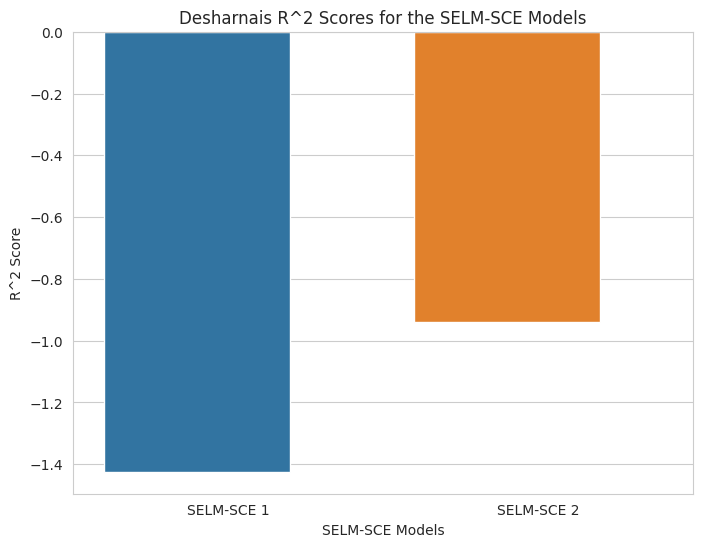

In [ ]:

# # Create a DataFrame with the model, dataset, and R2 scores
# desharnais_data = {
#     'Model': ['SELM-SCE 1', 'SELM-SCE 2', 'SELM-SCE 3', 'SELM-SCE 4', 'BOOSTED-SVM'],
#     'R2': [0.5373, 0.5912, 0.9314, 0.7633, 0.4218906630936132]
# }

plot_bar_chart(data=desh_result[['Model', 'R^2']])

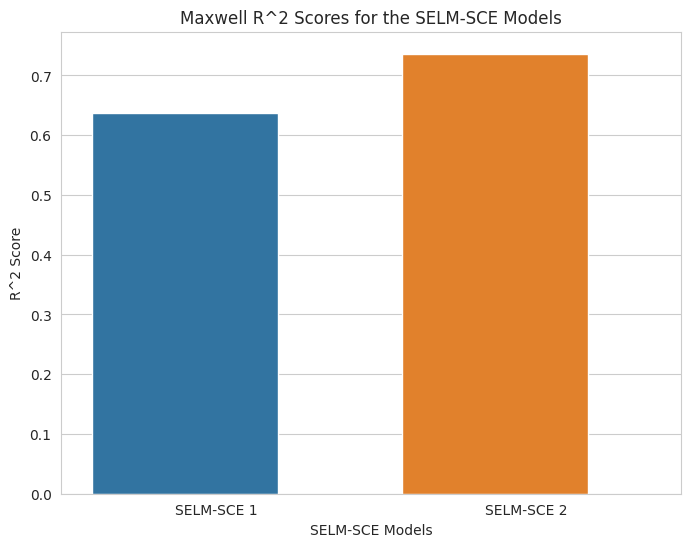

In [ ]:
# #
# maxwell_data = {
#     'Model': ['SELM-SCE 1', 'SELM-SCE 2', 'SELM-SCE 3', 'SELM-SCE 4'],
#     'R2': [0.7736, 0.7136, 0.9467, 0.9291, ]
# }

plot_bar_chart(data=maxwell_result[['Model', 'R^2']],  title='Maxwell R^2 Scores for the SELM-SCE Models')

### RMSE

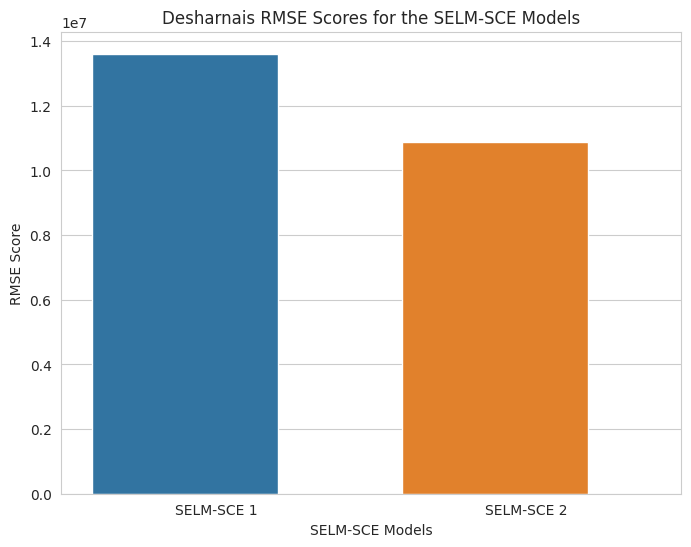

In [ ]:

# # Create a DataFrame with the model, dataset, and R2 scores
# desharnais_data = {
#     'Model': ['SELM-SCE 1', 'SELM-SCE 2', 'SELM-SCE 3', 'SELM-SCE 4', 'BOOSTED-SVM'],
#     'RMSE': [3543.6524,
#               3281.0011,
#               1687.0780,
#               3134.5499,
#              7683.678503833556]
# }

plot_bar_chart(data=desh_result[['Model', 'RMSE']], y='RMSE', title='Desharnais RMSE Scores for the SELM-SCE Models', y_label='RMSE Score')

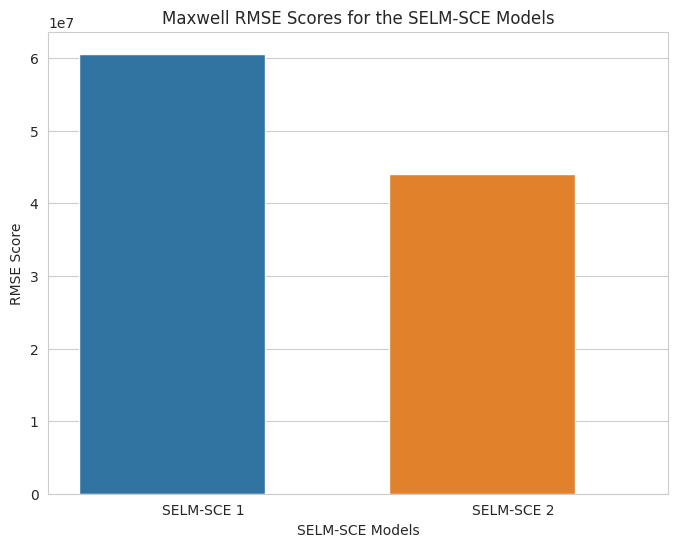

In [ ]:
#
# maxwell_data = {
#     'Model': ['SELM-SCE 1', 'SELM-SCE 2', 'SELM-SCE 3', 'SELM-SCE 4'],
#     'RMSE': [ 2903.4929,
#               3265.9219,
#               4532.7856,
#               5139.8344]
# }

plot_bar_chart(data=maxwell_result[['Model', 'RMSE']], y='RMSE', title='Maxwell RMSE Scores for the SELM-SCE Models', y_label='RMSE Score')

### MAE

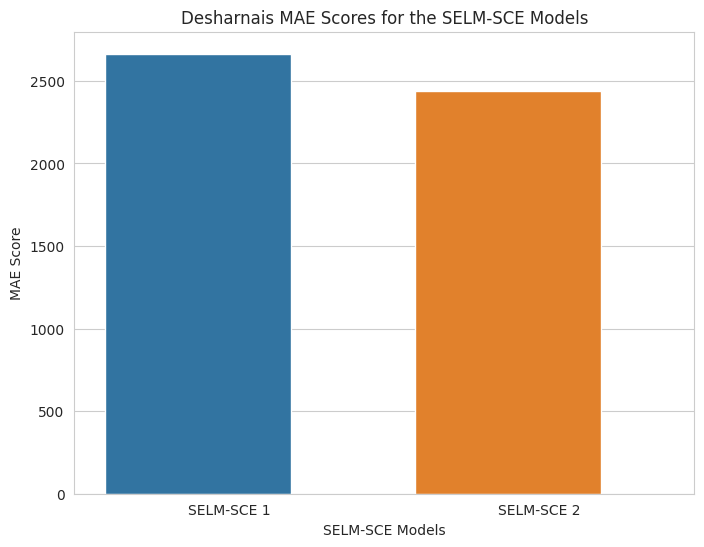

In [ ]:

# # Create a DataFrame with the model, dataset, and R2 scores
# desharnais_data = {
#     'Model': ['SELM-SCE 1', 'SELM-SCE 2', 'SELM-SCE 3', 'SELM-SCE 4', 'BOOSTED-SVM'],
#     'MAE': [2410.4528,
#             2439.0614,
#             1188.0015,
#             2103.4073,
#             6112.624327406135]
# }

plot_bar_chart(data=desh_result[['Model', 'MAE']], y='MAE', title='Desharnais MAE Scores for the SELM-SCE Models', y_label='MAE Score')

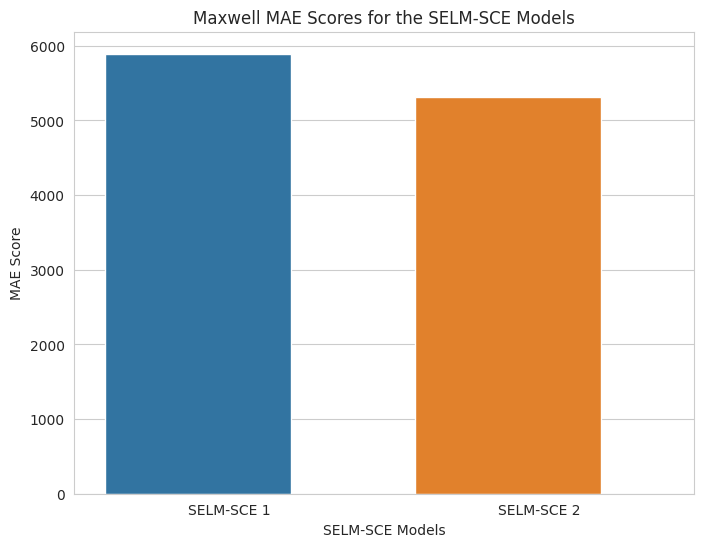

In [ ]:
# #
# maxwell_data = {
#     'Model': ['SELM-SCE 1', 'SELM-SCE 2', 'SELM-SCE 3', 'SELM-SCE 4'],
#     'MAE': [ 2299.1278,
#              2548.2762,
#              2550.9115,
#              2543.6997]
# }

plot_bar_chart(data=maxwell_result[['Model', 'MAE']], y='MAE', title='Maxwell MAE Scores for the SELM-SCE Models', y_label='MAE Score')

### Accuracy

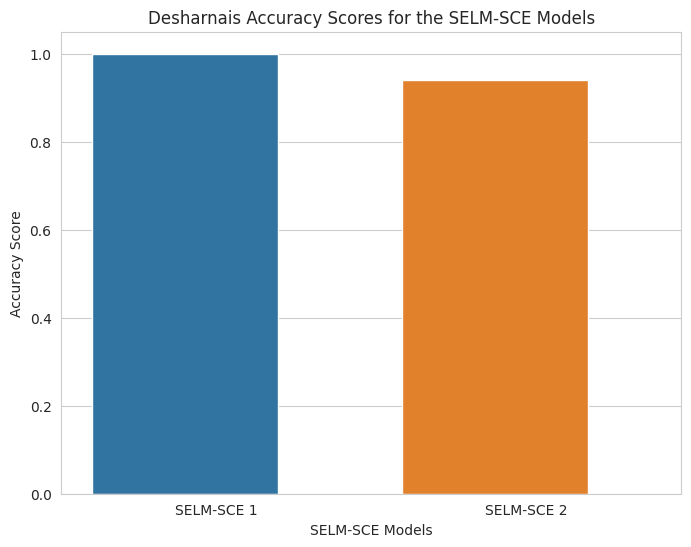

In [ ]:
plot_bar_chart(data=desh_result[['Model', 'Accuracy']], y='Accuracy', title='Desharnais Accuracy Scores for the SELM-SCE Models', y_label='Accuracy Score')


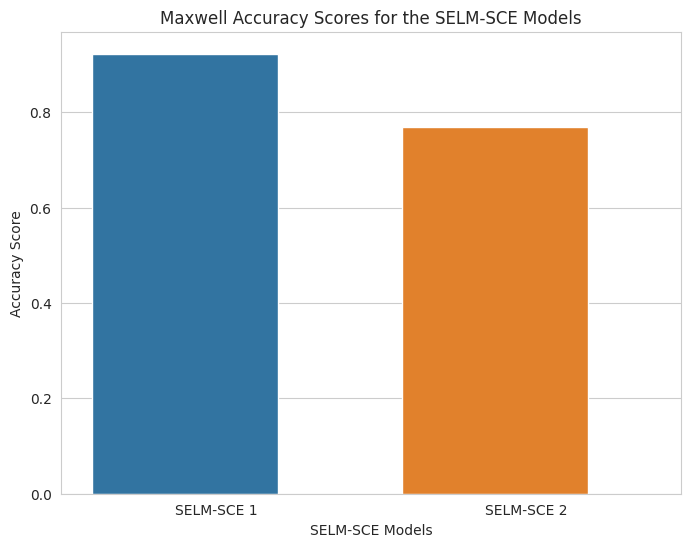

In [ ]:
plot_bar_chart(data=maxwell_result[['Model', 'Accuracy']], y='Accuracy', title='Maxwell Accuracy Scores for the SELM-SCE Models', y_label='Accuracy Score')


### Precision

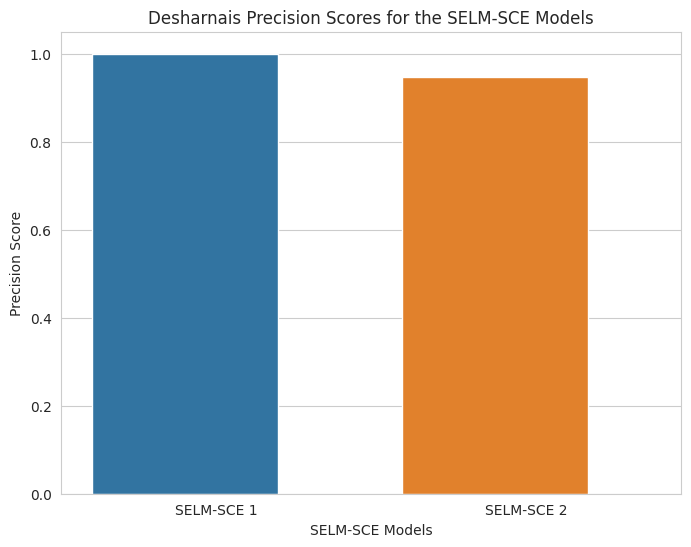

In [ ]:
plot_bar_chart(data=desh_result[['Model', 'Precision']], y='Precision', title='Desharnais Precision Scores for the SELM-SCE Models', y_label='Precision Score')


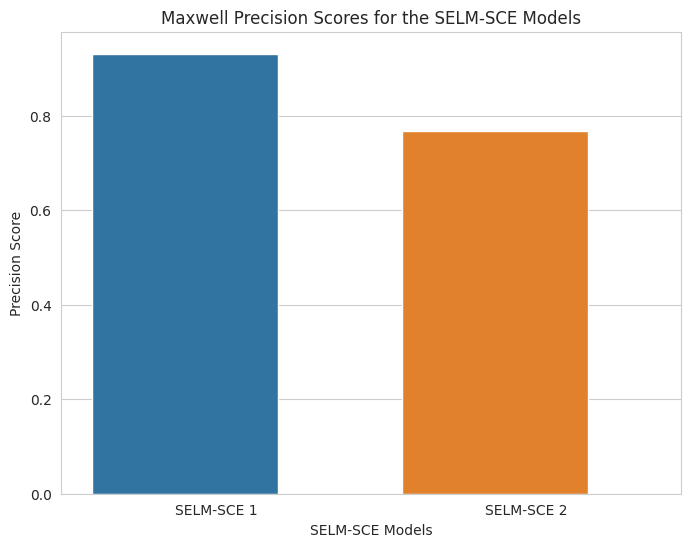

In [ ]:
plot_bar_chart(data=maxwell_result[['Model', 'Precision']], y='Precision', title='Maxwell Precision Scores for the SELM-SCE Models', y_label='Precision Score')


### Recall

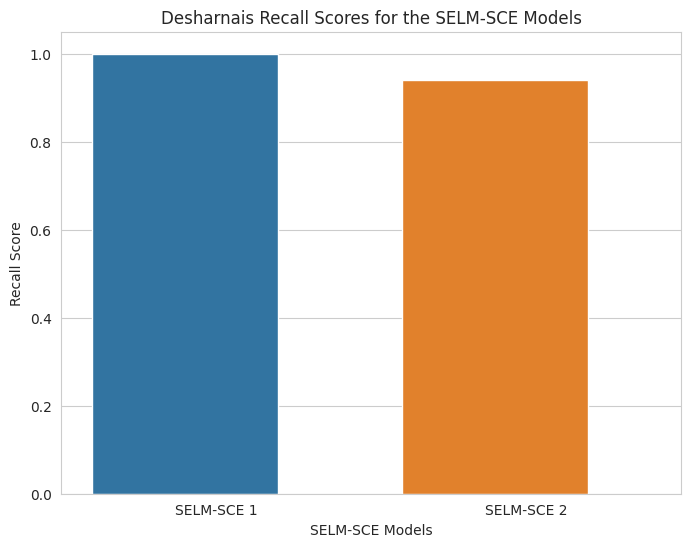

In [ ]:
plot_bar_chart(data=desh_result[['Model', 'Recall']], y='Recall', title='Desharnais Recall Scores for the SELM-SCE Models', y_label='Recall Score')


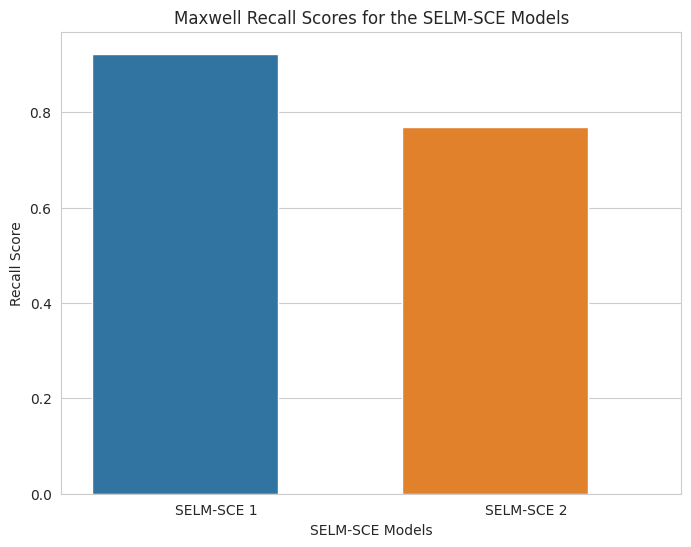

In [ ]:
plot_bar_chart(data=maxwell_result[['Model', 'Recall']], y='Recall', title='Maxwell Recall Scores for the SELM-SCE Models', y_label='Recall Score')


### F1 Score

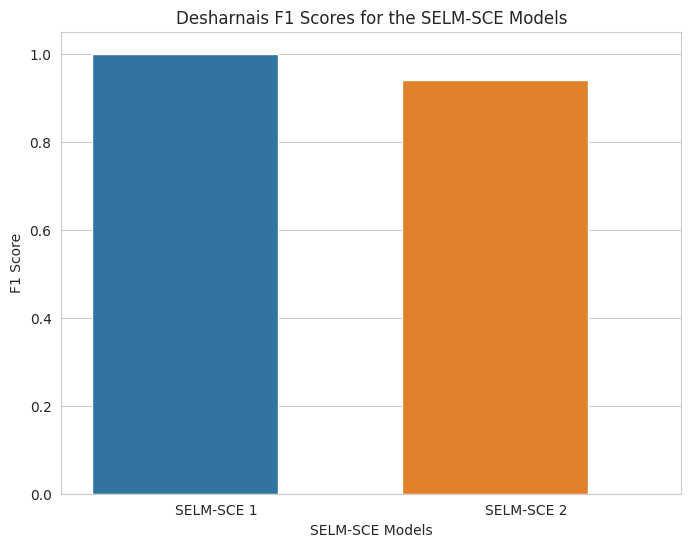

In [ ]:
plot_bar_chart(data=desh_result[['Model', 'F1-Score']], y='F1-Score', title='Desharnais F1 Scores for the SELM-SCE Models', y_label='F1 Score')


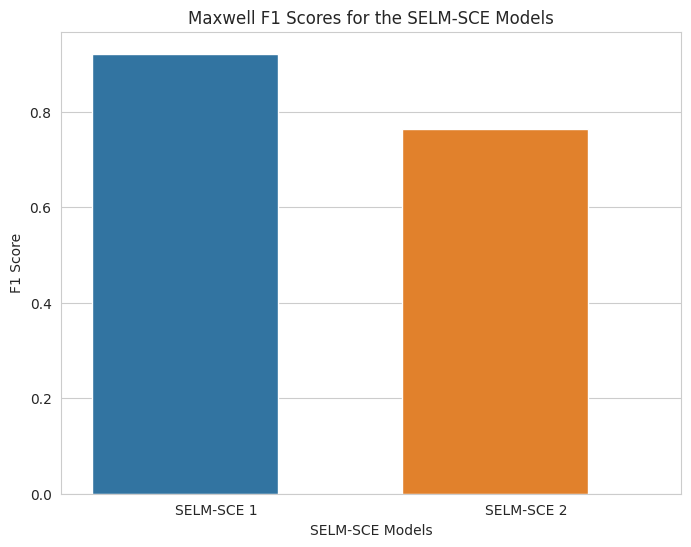

In [ ]:
plot_bar_chart(data=maxwell_result[['Model', 'F1-Score']], y='F1-Score', title='Maxwell F1 Scores for the SELM-SCE Models', y_label='F1 Score')


### Confusion Matrix 

In [ ]:
desh_result[['Model', 'Confusion Matrix']].to_numpy()[0]

array(['SELM-SCE 1', array([[ 6,  0],
       [ 0, 11]])], dtype=object)

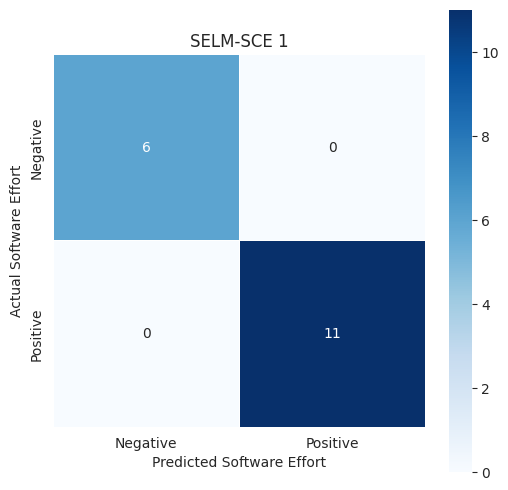

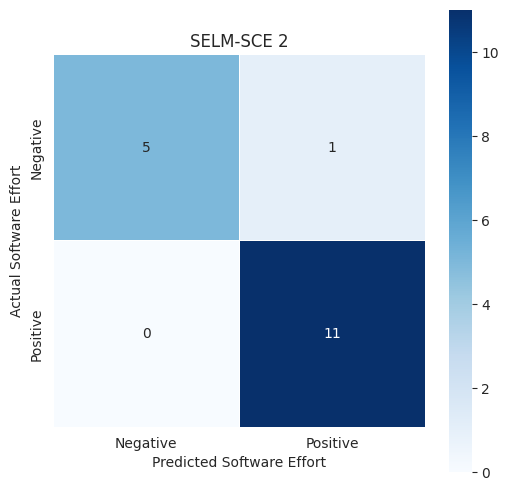

In [ ]:
desh_confusion_matrices = desh_result[['Model', 'Confusion Matrix']].to_numpy()

for cm_key, cm_value in desh_confusion_matrices:
  # Create a heatmap for the confusion matrix with 'Predicted' on the y-axis and 'Actual' on the x-axis
  conf_matrix = np.array(cm_value)
  labels =["Negative", "Positive"]

  plt.figure(figsize=(6, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, square=True, xticklabels=labels, yticklabels=labels)
  plt.title(cm_key)
  plt.xlabel('Predicted Software Effort')
  plt.ylabel('Actual Software Effort')
  plt.show()


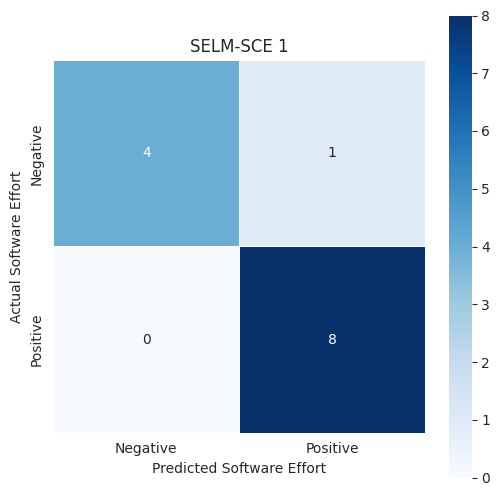

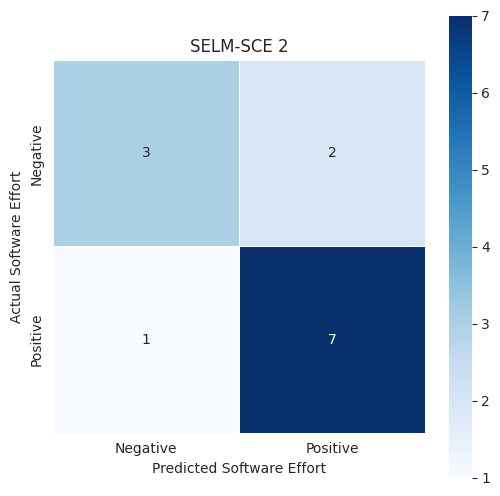

In [ ]:
maxwell_confusion_matrices = maxwell_result[['Model', 'Confusion Matrix']].to_numpy()

for cm_key, cm_value in maxwell_confusion_matrices:
  # Create a heatmap for the confusion matrix with 'Predicted' on the y-axis and 'Actual' on the x-axis
  conf_matrix = np.array(cm_value)
  labels =["Negative", "Positive"]

  plt.figure(figsize=(6, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, square=True, xticklabels=labels, yticklabels=labels)
  plt.title(cm_key)
  plt.xlabel('Predicted Software Effort')
  plt.ylabel('Actual Software Effort')
  plt.show()


# DUMP

In [ ]:
# def plot_bar_chart(data: dict, x: str = 'Model', y: str = 'R2',
#                    title: str = 'Desharnais R^2 Scores for the SELM-SCE Models',
#                    x_label: str = 'SELM-SCE Models',
#                    y_label: str = 'R^2 Score'):

#   df = pd.DataFrame(data)

#   # Create a bar chart using Seaborn
#   # Use bright color palette
#   # Define a color palette
#   colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
#   # colors = sns.color_palette("pastel", len(df))
#   plt.figure(figsize=(8, 6))
#   ax = sns.barplot(data=df, x=x, y=y, palette=colors, errorbar=None) # palette="coolwarm"
#   ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=10)
#   # Calculate custom positions for the x-axis labels
#   # tick_positions = range(len(df[x]))
#   # ax.set_xticks(tick_positions)
#   # ax.set_xticklabels(df[x], rotation=0, ha='right', fontsize=10)  # Set rotation to 0 and horizontal alignment to left

#   plt.title(title)
#   plt.xlabel(x_label)
#   plt.ylabel(y_label)
#   # Adjust the bar width
#   for bar in ax.patches:
#       bar.set_width(0.6)  # Change the width as per your preference

#   plt.show()


In [ ]:
# models_metrics_df = pd.DataFrame()

# model_args: Dict  = {
#     'maxwell_without_kmeans': ModelTestingArgs(X_test_data_path='dataset/maxwell_X_test_sca.csv', y_test_data_path='dataset/maxwell_y_test.csv',
#                                                maxwell_dataset=True, val_model='models/maxwell_without_kmeans'),
#     'maxwell_with_kmeans': ModelTestingArgs(X_test_data_path='dataset/maxwell_X_test_sca.csv', y_test_data_path='dataset/maxwell_y_test.csv',
#                                                maxwell_dataset=True, val_model='models/maxwell_with_kmeans'),
#     'desh_without_kmeans': ModelTestingArgs(X_test_data_path='dataset/desh_X_test_sca.csv', y_test_data_path='dataset/desh_y_test.csv',
#                                                maxwell_dataset=False, val_model='models/desh_without_kmeans'),
#     'desh_with_kmeans': ModelTestingArgs(X_test_data_path='dataset/desh_X_test_sca.csv', y_test_data_path='dataset/desh_y_test.csv',
#                                                maxwell_dataset=False, val_model='models/desh_with_kmeans'),
# }

# # desharnais_data = {
# #     'Model': ['SELM-SCE 1', 'SELM-SCE 2', 'SELM-SCE 3', 'SELM-SCE 4', 'BOOSTED-SVM'],
# #     'R2': [0.5373, 0.5912, 0.9314, 0.7633, 0.4218906630936132]
# # }

# trained_models: List = {
#     'Model': ['SELM-SCE 1', 'SELM-SCE 2'],
# }
# for model_args in model_args:
#     test_model(model_args)
    

In [ ]:
# def parse_arguments():
#     """
#     Parses command-line arguments and returns a DatasetProcessingArgs object.
#     """

#     parser = argparse.ArgumentParser("Process dataset")

#     parser.add_argument('-max', "--maxwel_dset", type=int, required=True,
#                         help="Specify if dataset to be worked on is maxwell or desharnais.")
#     parser.add_argument("-dp", "--datapath", required=True, type=str,
#                         help="folder path that containing data to be processed.")
#     parser.add_argument('-sd', "--split_data", type=int, default=0,
#                         help="if True dataset will be splited")
#     parser.add_argument('-sds', "--save_dataset", type=int, default=0,
#                         help="if True process dataset will be saved")
#     parser.add_argument('-sp', "--scalar_split", type=int, default=0,
#                         help="if True data will be scaled")
#     parser.add_argument('-ss', "--save_scalar", type=int, default=0,
#                         help="if True model used to scale data will be saved will be saved")

#     args = parser.parse_args()

#     return DatasetProcessingArgs(
#         maxwell_dset=args.maxwel_dset,
#         datapath=args.datapath,
#         split_data=args.split_data,
#         save_dataset=args.save_dataset,
#         scalar_split=args.scalar_split,
#         save_scalar=args.save_scalar,
#     )

# # Example usage
# arguments = parse_arguments()
# print(f"Processing Maxwell dataset: {arguments.maxwell_dset}")
# print(f"Data path: {arguments.datapath}")

In [ ]:
# from dataclasses import dataclass

# @dataclass
# class ModelTrainingArgs:
#     """
#     Class to hold arguments for model training.

#     Attributes (all optional except data paths):
#         Xtrain_datapath (str): Path to the CSV file containing Xtrain data. (required)
#         ytrain_datapath (str): Path to the CSV file containing ytrain data. (required)
#         maxwell_dataset (bool): Whether the dataset is from Maxwell (if True) or Desharnais (if False). (required)
#         with_kmeans (int): Flag indicating whether to use kmeans (1 for yes, 0 for no). Defaults to 0.
#         testmodel (str): Path to a pre-trained model (.joblib file). Defaults to None.
#         traindata_is_scaled (int): Flag indicating if the training data is already scaled (1 for yes, 0 for no). Defaults to 1.
#         scaler_path (str): Path to a pre-trained scaler (if using traindata_is_scaled=0). Defaults to None.
#         save_model (int): Flag indicating whether to save the trained model (1 for yes, 0 for no). Defaults to 0.
#         model_out_name (str): Name for the saved model file. Defaults to 'model'.
#     """

#     Xtrain_datapath: str
#     ytrain_datapath: str
#     maxwell_dataset: bool
#     with_kmeans: int = 0
#     testmodel: str = None
#     traindata_is_scaled: int = 1
#     scaler_path: str = None
#     save_model: int = 0
#     model_out_name: str = 'model'

# def build_argparser():
#     """
#     Parse command line arguments.

#     Returns:
#         argparse.Namespace: Parsed command line arguments.
#     """
#     parser = argparse.ArgumentParser("Train a model")

#     # -- Add required and optional groups
#     parser._action_groups.pop()
#     required = parser.add_argument_group('required arguments')
#     optional = parser.add_argument_group('optional arguments')

#     required.add_argument('-max', "--maxwel_dset", type=int, help="Specify if dataset to be worked on is maxwell or desharnais.")
#     required.add_argument("-xtdp", "--Xtrain_datapath", required=True, type=str, 
#                             help="csv file that containing Xtrain on.")

#     required.add_argument("-ytdp", "--ytrain_datapath", required=True, type=str, 
#                             help="csv file that containing ytrain.")
    
#     optional.add_argument("-wkm", "--with_kmeans", type=int, default=0,
#                             help="train with kmeans.")

#     optional.add_argument("-tm", "--testmodel", type=str, default=None,
#                             help="path to .joblib file with a trained model.")
    
#     optional.add_argument("-ts", "--traindata_is_scaled", type=int, default=1,
#                             help="to load data with scaling or without scaling")


#     optional.add_argument('-sp', "--scaler_path", type=str, default=None, 
#                             help="path to pretrained scaler, used to scale the train dataset")

#     optional.add_argument('-sm', "--save_model", type=int, default=0, help="Save trained model?.")
#     optional.add_argument('-mon', "--model_out_name", type=str, default='model', help="name to save the model as.")
    
#     return parser

# def parse_args():
#   """
#   Parses command line arguments and creates a ModelTrainingArgs object.

#   Returns:
#       ModelTrainingArgs: Parsed training arguments.
#   """
#   parser = build_argparser()
#   args = parser.parse_args()
#   return ModelTrainingArgs(
#       Xtrain_datapath=args.Xtrain_datapath,
#       ytrain_datapath=args.ytrain_datapath,
#       maxwell_dataset=bool(args.maxwel_dset),  # Convert int to bool
#       with_kmeans=args.with_kmeans,
#       testmodel=args.testmodel,
#       traindata_is_scaled=args.traindata_is_scaled,
#       scaler_path=args.scaler_path,
#       save_model=args.


In [ ]:
# from dataclasses import dataclass

# @dataclass
# class ModelTestingArgs:
#   """
#   Class to hold arguments for model testing.

#   Attributes (all optional except data paths and model path):
#       Xval_datapath (str): Path to the CSV file containing Xval data. (required)
#       yval_datapath (str): Path to the CSV file containing yval data. (required)
#       maxwell_dataset (bool): Whether the dataset is from Maxwell (if True) or Desharnais (if False). (required)
#       valmodel (str): Path to the trained model file (.pt or .pth). (required)
#       scaler_path (str): Path to a pre-trained scaler (if needed for data scaling). Defaults to None.
#   """

#   Xval_datapath: str
#   yval_datapath: str
#   maxwell_dataset: bool
#   valmodel: str
#   scaler_path: str = None

# def build_argparser():
#   """
#   Parse command line arguments for model testing.

#   Returns:
#       argparse.Namespace: Parsed command line arguments.
#   """
#   parser = argparse.ArgumentParser("Test a Model")

#   # -- Add required and optional groups
#   parser._action_groups.pop()
#   required = parser.add_argument_group('required arguments')
#   optional = parser.add_argument_group('optional arguments')

#   required.add_argument('-max', "--maxwel_dset", type=int,
#                         help="Specify if dataset to be worked on is maxwell or desharnais.")
#   required.add_argument("-xvdp", "--Xval_datapath", required=True, type=str,
#                         help="folder path that containing Xval.")
#   required.add_argument("-yvdp", "--yval_datapath", required=True, type=str,
#                         help="csv file that containing yval.")

#   required.add_argument("-vm", "--valmodel", type=str, required=True,
#                         help="path to .pt or pth file with a trained model.")
#   optional.add_argument('-sp', "--scaler_path", type=str, default=None,
#                         help="path to pretrained scaler, used to scale the val dataset")
#   return parser

# def parse_test_args():
#   """
#   Parses command line arguments and creates a ModelTestingArgs object.

#   Returns:
#       ModelTestingArgs: Parsed testing arguments.
#   """
#   parser = build_argparser()
#   args = parser.parse_args()
#   return ModelTestingArgs(
#       Xval_datapath=args.Xval_datapath,
#       yval_datapath=args.yval_datapath,
#       maxwell_dataset=bool(args.maxwel_dset),  # Convert int to bool
#       valmodel=args.valmodel,
#       scaler_path=args.scaler_path
#   )


## Models Train-Test Framework

In [ ]:


# def roc_auc_score_multiclass(
#     model: ClassifierMixin, X_test: np.ndarray, y_test: np.ndarray
# ) -> Tuple[int, Dict[Any, float], Dict[Any, float], Dict[Any, float], Dict[Any, float]]:
#     """
#     Calculate the ROC AUC score for a multi-class classification problem.

#     Parameters:
#     - model: The trained classifier model.
#     - X_test: Testing data.
#     - y_test: True class labels.

#     Returns:
#     - Tuple of containing number of classes(int) | fpr, tpr, and ROC AUC score for each class.
#     """
#     predictions = model.predict_proba(X_test)
#     n_classes = predictions.shape[1]

#     # Ensure y_test is an array (convert from list if needed)
#     y_test = np.array(y_test)

#     # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     thresholds = dict()
#     roc_auc = dict()

#     for i in range(n_classes):
#         fpr[i], tpr[i], thresholds[i] = roc_curve(
#             (y_test == i).astype(int), predictions[:, i]
#         )
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     return n_classes, fpr, tpr, thresholds, roc_auc

# class ModelSelection:
#     def __init__(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray) -> None:
#         self.X_train = X_train
#         self.X_test = X_test
#         self.y_train = y_train
#         self.y_test = y_test
        
#         self.models: Dict[str, ClassifierMixin] = {}  # Dictionary to store models
#         self.metrics: Dict[str, Dict[str, Any]] = (
#             {}
#         )  # Dictionary to store evaluation metrics
        
#         self.best_model_name: str = ""
        
#         # Colors for plotting
#         self.COLORS: List[str] = [
#             "brown",
#             "coral",
#             "green",
#             "yellow",
#             "black",
#             "gray",
#             "red",
#             "blue",
#             "purple",
#             "pink",
#             "orange",
#             "olive",
#             "skyblue",
#             "cornflowerblue",
#             "cyan",
#             "aqua",
#             "darkorange",
#             "teal",
#             "magenta",
#             "tan",
#         ]
        
#     def add_model(
#         self, name: str, model: ClassifierMixin, replace: bool = False
#     ) -> None:
#         """
#         Add a machine learning model to the selection.

#         Parameters:
#         - name: A unique name for the model.
#         - model: The machine learning model to add.
#         - replace: If True, replace the existing model with the same name.
#         """
#         if name in self.models and not replace:
#             print(
#                 f"Warning: Model with name '{name}' already exists. Skipping addition."
#             )
#         else:
#             self.models[name] = model

#     def remove_model(self, name: str) -> None:
#         """
#         Remove a machine learning model from the selection.

#         Parameters:
#         - name: The name of the model to remove.
#         """
#         if name in self.models:
#             del self.models[name]
#         else:
#             print(f"Warning: Model with name '{name}' does not exists.")
            
#     def train_models(self) -> None:
#         """
#         Train all added models and evaluate their performance.
#         """
#         total_models = len(self.models)

#         for i, (name, model) in enumerate(self.models.items(), 1):
#             print(f"Training model {i} of {total_models}: {name}")
#             self.models[name] = model.fit(self.X_train, self.y_train)
#             self.evaluate_model(name, model, self.X_test, self.y_test)
#             print(f"Model {i} of {total_models} trained")
    
#     def evaluate_model(
#         self,
#         name: str,
#         model: ClassifierMixin,
#         X_test: np.ndarray,
#         y_test: np.ndarray,
#         save: bool = True,
#     ) -> Dict[str, Any]:
#         """
#         Evaluate a model using common classification metrics.

#         Parameters:
#         - name: Name of the model.
#         - model: The trained machine learning model.
#         - X_test: Testing data.
#         - y_test: True labels for the test set.
#         - save: If True, save metrics to the metrics dictionary.

#         Returns:
#         - Dictionary containing evaluation metrics.
#         """
#         predictions = model.predict(X_test)

#         accuracy = accuracy_score(y_test, predictions, average="weighted")
#         precision = precision_score(y_test, predictions, average="weighted")
#         recall = recall_score(y_test, predictions, average="weighted")
#         f1 = f1_score(y_test, predictions, average="weighted")
#         cm = confusion_matrix(y_test, predictions)
#         mislabeled_points = (y_test.flatten() != predictions.flatten()).sum()

#         if self.multi_class:
#             _, _, _, _, auc_score = roc_auc_score_multiclass(model, X_test, y_test)
#         else:
#             auc_score = roc_auc_score(
#                 np.array(y_test),
#                 np.array(predictions),
#                 average="weighted",
#             )

#         metrics = {
#             "accuracy": accuracy,
#             "precision": precision,
#             "recall": recall,
#             "f1_score": f1,
#             "roc_auc": auc_score,
#             "confusion_matrix": cm,
#             "mislabeled_points": mislabeled_points,
#         }

#         if save:
#             self.metrics[name] = metrics

#         return metrics
    
    # def get_best_model(
    #     self, metric: str = "f1_score"
    # ) -> Tuple[ClassifierMixin, str, Dict[str, Any]]:
    #     """
    #     Get the best model based on a specified metric.

    #     Parameters:
    #     - metric: The metric to use for comparison. (accuracy | precision, recall, | f1_score | roc_auc)

    #     Returns:
    #     - Tuple containing the best model, its name, and corresponding metrics.
    #     """
    #     if (
    #         metric != "confusion_matrix"
    #         or metric != "mislabeled_points"
    #         or len(self.metrics) != 0
    #     ):
    #         self.best_model_name = max(
    #             self.metrics, key=lambda x: self.metrics[x][metric]
    #         )
    #         best_model = self.models[self.best_model_name]

    #         return best_model, self.best_model_name, self.metrics[self.best_model_name]

    #     return None
    
    # def plot_confusion_matrix(
    #     self,
    #     model_name: Optional[str] = None,
    #     all_models=False,
    #     # all_models_title: str = "Confusion Matrix for All Models",
    #     file_path="plots/confusion_matrix.png",
    # ) -> None:
    #     """
    #     Plot the confusion matrix for a given model in the models list.

    #     Parameters:
    #     - model_name: The name of the model to plot the confusion matrix for.
    #     """
    #     if not all_models:
    #         if model_name is None:
    #             _, model_name, _ = self.get_best_model()

    #         cm = self.metrics[model_name]["confusion_matrix"]

    #         # Plotting the confusion matrix with numbers
    #         plt.figure(figsize=(8, 6))
    #         sns.heatmap(
    #             cm,
    #             annot=True,
    #             fmt="d",
    #             cmap="Blues",
    #             cbar=True,
    #             xticklabels=np.unique(self.y_test),
    #             yticklabels=np.unique(self.y_test),
    #         )

    #         plt.title(f"Confusion Matrix for {model_name}")
    #         plt.xlabel("Predicted Label")
    #         plt.ylabel("True Label")
    #         plt.show()

    #     else:
    #         # Assuming 'models' is a dictionary containing your models
    #         num_models = len(self.models)
    #         grid_size = int(math.ceil(math.sqrt(num_models)))

    #         # Create a Subplots Grid
    #         fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20), dpi=400)
    #         axes = axes.ravel()

    #         # Iterate Over Models
    #         for i, model_key in enumerate(self.models):
    #             metrics = self.metrics[model_key]
    #             cm = metrics["confusion_matrix"]

    #             # Plot Heatmap
    #             sns.heatmap(
    #                 cm,
    #                 annot=True,
    #                 ax=axes[i],
    #                 fmt="g",
    #                 cmap="Blues",
    #                 annot_kws={"size": 16},
    #             )

    #             # Set Title and Labels
    #             axes[i].set_title(
    #                 list(self.models.keys())[i], fontsize=16, fontweight="bold"
    #             )
    #             axes[i].set_xlabel("Predicted", fontsize=14, fontweight="bold")
    #             axes[i].set_ylabel("Actual", fontsize=14, fontweight="bold")

    #         # Remove Empty Plots
    #         for j in range(num_models, grid_size * grid_size):
    #             fig.delaxes(axes[j])

    #         # Adjust Layout and Save/Show
    #         fig.tight_layout()
    #         if len(file_path) > 0:
    #             plt.savefig(file_path)

    #         # plt.title(all_models_title)
    #         plt.show()

    # def plot_bar_chart(
    #     self,
    #     model_name: Optional[str] = None,
    #     all_models: bool = False,
    #     palette: str = "viridis",
    #     # all_models_title: str = "Evaluation Metrics for All Models",
    #     file_path: str = "plots/accuracy_precision_recall_f1_score1.png",
    # ) -> None:
    #     """
    #     Plot a bar chart comparing evaluation metrics for a given model or all models.

    #     Parameters:
    #     - model_name: The name of the model to plot the metrics for. If None, the best model is chosen.
    #     - all_models: If True, plot metrics for all models in the selection.
    #     - palette: The color palette to use for the bar chart.
    #     - file_path: Directory to save the resulting bar chart.
    #     """
    #     if not all_models:
    #         if model_name is None:
    #             _, model_name, _ = self.get_best_model()

    #         metrics = self.metrics[model_name]

    #         accuracy = metrics["accuracy"]
    #         precision = metrics["precision"]
    #         recall = metrics["recall"]
    #         f1_score = metrics["f1_score"]

    #         plt.figure(figsize=(8, 6))
    #         # Plot Metrics as Bar Chart
    #         sns.barplot(
    #             x=["accuracy", "precision", "recall", "f1_score"],
    #             y=[accuracy, precision, recall, f1_score],
    #             palette=palette,
    #             alpha=0.8,
    #         )
    #         plt.title(f"Evaluation Metrics for {model_name}")
    #         plt.xlabel("Metrics")
    #         plt.ylabel("Score")
    #         plt.show()

    #     else:
    #         num_models = len(self.models)
    #         grid_size = int(math.ceil(math.sqrt(num_models)))

    #         # Create a Subplots Grid
    #         fig, axes = plt.subplots(grid_size, grid_size, figsize=(25, 25), dpi=400)
    #         axes = axes.ravel()

    #         # Iterate Over Models
    #         for i, model_key in enumerate(self.models):
    #             metrics = self.metrics[model_key]
    #             accuracy = metrics["accuracy"]
    #             precision = metrics["precision"]
    #             recall = metrics["recall"]
    #             f1_score = metrics["f1_score"]

    #             # Plot Metrics as Bar Chart
    #             sns.barplot(
    #                 x=["accuracy", "precision", "recall", "f1_score"],
    #                 y=[accuracy, precision, recall, f1_score],
    #                 ax=axes[i],
    #                 palette=palette,
    #                 alpha=0.8,
    #             )

    #             # Increase labels font size
    #             axes[i].tick_params(axis="both", which="major", labelsize=14)
    #             axes[i].set_title(model_key, fontsize=16, fontweight="bold")
    #             axes[i].set_xlabel("Metric", fontsize=14, fontweight="bold")
    #             axes[i].set_ylabel("Score", fontsize=14, fontweight="bold")

    #         # Remove Empty Plots
    #         for j in range(num_models, grid_size * grid_size):
    #             fig.delaxes(axes[j])

    #         # Adjust Layout and Save/Show
    #         fig.tight_layout()
    #         if len(file_path) > 0:
    #             plt.savefig(file_path)

    #         # plt.title(all_models_title) # loc="right", y=-0.25, x=0.5
    #         plt.show()

    # def plot_roc_curve(
    #     self,
    #     models: Optional[Dict[str, ClassifierMixin]] = None,
    #     multi_class: bool = False,
    #     file_path: Optional[str] = "plots/roc_curve.png",
    #     all_models: bool = False,
    #     # all_models_title: str = "ROC-AUC Curve for All Models"
    # ) -> None:
    #     """
    #     Plot the ROC curve for each model in one figure.

    #     Parameters:
    #     - models: A dictionary of machine learning models with their names as keys.
    #     - multi_class: If True, evaluate AUC for multiclass. Default is False.
    #     - file_path: File path to save the resulting ROC curve plot. Default is "plots/roc_curve.png".
    #     - all_models: If True, plot ROC curves for all models. Default is False.
    #     """
    #     if models is None and not all_models:
    #         model, model_name, _ = self.get_best_model()

    #         if not hasattr(model, "predict_proba"):
    #             raise AttributeError(
    #                 f"Model {model_name} does not have a predict_proba method."
    #             )

    #         n_classes, fpr, tpr, thresholds, roc_auc = roc_auc_score_multiclass(
    #             model, self.X_test, self.y_test
    #         )

    #         # Plot ROC curve for each class
    #         plt.figure()
    #         for i, color in zip(range(n_classes), self.COLORS):
    #             plt.plot(
    #                 fpr[i],
    #                 tpr[i],
    #                 color=color,
    #                 lw=2,
    #                 label=f"ROC curve (area = {roc_auc[i]:.2f}) for class {i}",
    #             )

    #         plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    #         plt.xlabel("False Positive Rate")
    #         plt.ylabel("True Positive Rate")
    #         plt.title(f"ROC-AUC Curve for {model_name}")
    #         plt.legend(loc="lower right", borderaxespad=0)  # Adjust the legend layout
    #         plt.show()

    #         return

    #     if all_models:
    #         models = self.models

    #     num_models = len(models)
    #     grid_size = int(math.ceil(math.sqrt(num_models)))

    #     # Create a Subplots Grid
    #     fig, axes = plt.subplots(grid_size, grid_size, figsize=(25, 30), dpi=400)
    #     axes = axes.ravel()
    #     error_axes = []

    #     for i, (model_name, model) in enumerate(models.items()):
    #         try:
    #             if not hasattr(model, "predict_proba"):
    #                 raise AttributeError(
    #                     f"Model {model_name} does not have a predict_proba method."
    #                 )

    #             if multi_class:
    #                 n_classes, fpr, tpr, thresholds, roc_auc = roc_auc_score_multiclass(
    #                     model, self.X_test, self.y_test
    #                 )

    #                 # Plot ROC curve for each class
    #                 for j, color in zip(range(n_classes), self.COLORS):
    #                     axes[i].plot(
    #                         fpr[j],
    #                         tpr[j],
    #                         color=color,
    #                         lw=2,
    #                         label=f"ROC curve (area = {roc_auc[j]:.2f}) for class {j}",
    #                     )
    #             else:
    #                 predictions = model.predict_proba(self.X_test)
    #                 fpr, tpr, thresholds = roc_curve(np.array(self.y_test), predictions)
    #                 roc_auc = auc(fpr, tpr)

    #                 # plot the roc curve
    #                 axes[i].plot(
    #                     fpr,
    #                     tpr,
    #                     color=self.COLORS[i],
    #                     lw=2,
    #                     label="ROC curve (area = %0.2f)" % roc_auc,
    #                 )

    #             # plot the random line
    #             axes[i].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    #             # set the limits
    #             axes[i].set_xlim([0.0, 1.0])
    #             axes[i].set_ylim([0.0, 1.05])
    #             # set the labels
    #             axes[i].set_xlabel(
    #                 "False Positive Rate", fontsize=14, fontweight="bold"
    #             )
    #             axes[i].set_ylabel("True Positive Rate", fontsize=14, fontweight="bold")
    #             axes[i].set_title(model_name, fontsize=16, fontweight="bold")
    #             axes[i].legend(
    #                 loc="lower right", borderaxespad=0
    #             )  # Adjust the legend layout

    #         except Exception as e:
    #             error_axes.append(i)
    #             print(f"Error for model {model_name}: {str(e)}")
    #             pass

    #     # Remove Empty Plots
    #     for j in range(num_models, grid_size * grid_size):
    #         fig.delaxes(axes[j])

    #     fig.tight_layout()

    #     if len(file_path) > 0:
    #         plt.savefig(file_path)

    #     # plt.title(all_models_title)
    #     plt.show()
    
          